In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import ipywidgets as widgets

from ipywidgets import interact, Dropdown
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

# Data Prep

In [3]:
path = "../../DataTrimmed/"
dfs = {}

In [4]:
def prepare_df(df):
    df.rename(columns={'Geo_NAME': 'zip_code'}, inplace=True)
    df = df.loc[pd.to_numeric(df.zip_code).between(10000,20000)] # Filtering rows to limit the data we work on. Selecting group of states starting with 1
    df.set_index('zip_code', inplace=True)
    table_names = ['SE_B13004', 'SE_B18002', 'SE_A03001', 'SE_A13007', 'SE_A14028','SE_A14024_', 'SE_B12001', 'SE_A12003', 'SE_A12004', 'SE_A17005', 'SE_A17009', 'SE_A20001', 'SE_A00002','SE_A10036','SE_A18009']
    matching_columns = [col for col in df.columns if col.startswith(tuple(table_names))]
    df = df.loc[:, df.columns.isin(matching_columns)]
    df = df.astype(float)
    df = df.dropna() # Drop rows with missing values

    return df


In [5]:
def process_columns(df):
    df['underPoverty'] = np.where(df[('SE_B13004_005')].div(df[('SE_B13004_001')]) < 0.5,1,0) 
    df = df.loc[: ,~df.columns.str.startswith('SE_B13004')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A13007_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'incomeBelowPovertyLevelProportion'] = ((df.loc[:,('SE_A13007_002')].values) /(df.loc[:,('SE_A13007_001')].values))
    df.incomeBelowPovertyLevelProportion.describe()
    df = df.loc[: ,~df.columns.str.startswith('SE_A13007')] # Drop the columns from the table after processing

    df.loc[:, 'incomePerCapita'] = df.loc[: ,df.columns.str.startswith('SE_A14024_001')].values
    df = df.loc[: ,~df.columns.str.startswith('SE_A14024')] # Drop the columns from the table after processing

    df.loc[:, 'incomeGiniIndex'] = df.loc[: ,df.columns.str.startswith('SE_A14028_001')] 
    df = df.loc[: ,~df.columns.str.startswith('SE_A14028')] # Drop the columns from the table after processing

    df.loc[:, 'popDensity'] = df.loc[:,('SE_A00002_002')].values 
    df = df.loc[: ,~df.columns.str.startswith('SE_A00002')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A03001_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'whiteMajority'] = ((df.loc[:,'SE_A03001_002'].values) / (df.loc[:,'SE_A03001_001'].values)) # If the proportion of white alone population is more than 50% we set this binary variable to 1
    df = df.loc[: ,~df.columns.str.startswith('SE_A03001')] # Drop the columns from the table after processing

    df = df.loc[df['SE_B12001_001'] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'eduHsOrLessProportion'] = ((df.loc[:,('SE_B12001_002')].values) / (df.loc[:,('SE_B12001_001')].values)) # Proportion of 25yo and over with less than high school education
    df.loc[:, 'eduHsProportion'] = ((df.loc[:,('SE_B12001_003')].values) / (df.loc[:,('SE_B12001_001')].values)) # Proportion of 25yo and over with less than high school education
    df.loc[:, 'eduBachOrBetterProportion'] = ((df.loc[:,('SE_B12001_004')].values) / (df.loc[:,('SE_B12001_001')].values)) # Proportion of 25yo and over with less than high school education
    df = df.loc[: ,~df.columns.str.startswith('SE_B12001_')] # Drop the columns from the table after processing

    df.loc[:, 'eduEnrollmentProportion'] = ((df.loc[:,('SE_A12004_002')].values) / (df.loc[:,('SE_A12004_001')].values)) # If the proportion of 3yo and over enrolled in school is more than 50% we set this binary variable to 1
    df = df.loc[: ,~df.columns.str.startswith('SE_A12004')] # Drop the columns from the table after processing

    df = df.loc[df['SE_A12003_001'] != 0] # Some of the zip codes have 0 civilian population. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'eduDropoutProportion'] = ((df.loc[:,('SE_A12003_002')].values) / (df.loc[:,('SE_A12003_001')].values)) # If the proportion of late teens dropped out from school is more than 50% we set this binary variable to 1
    df = df.loc[: ,~df.columns.str.startswith('SE_A12003')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A17005_001')] != 0] # Some of the zip codes have 0 civilian population. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'employedProportion'] = ((df.loc[:,('SE_A17005_002')].values) / (df.loc[:,('SE_A17005_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A17005')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A17009_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'employedPvtSecProportion'] = ((df.loc[:,('SE_A17009_002')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedPubSecProportion'] = ((df.loc[:,('SE_A17009_003')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedSelfEmpProportion'] = ((df.loc[:,('SE_A17009_004')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedPvtNonProProportion'] = ((df.loc[:,('SE_A17009_005')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedUnpaidFamProportion'] = ((df.loc[:,('SE_A17009_006')].values) / (df.loc[:,('SE_A17009_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A17009')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A20001_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'insuredProportion'] = ((df.loc[:,('SE_A20001_003')].values) / (df.loc[:,('SE_A20001_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A20001')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:, ('SE_B18002_001')] != 0] # Remove observations with 0 to avoid error while dividing
    df.loc[:, 'housingRentMoreThan30pcProportion'] = ((df.loc[:,('SE_B18002_002')].values + df.loc[:,('SE_B18002_003')].values ) / (df.loc[:,('SE_B18002_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_B18002')] # Drop the columns from the table after processing

    df.loc[:, 'housingMedianValue'] = ((df.loc[:,('SE_A10036_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A10036_')] # Drop the columns from the table after processing

    df.loc[:, 'housingMedianGrossRent'] = ((df.loc[:,('SE_A18009_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A18009')] # Drop the columns from the table after processing

    return df



    

In [6]:
%%time
print("Working on data.............")
for year in range(2017,2022):
    print(f"Processing {year}")
    df_name = f'df{year}'
    filepath = path + str(year) + '_trimmed.csv'
    dfs[df_name] = pd.read_csv(filepath)
    print(f"Preparing df{year} for processing")
    dfs[df_name] = prepare_df(dfs[df_name])
    print(f"Processing df{year} columns")
    dfs[df_name] = process_columns(dfs[df_name])

Working on data.............
Processing 2017
Preparing df2017 for processing
Processing df2017 columns
Processing 2018
Preparing df2018 for processing
Processing df2018 columns
Processing 2019
Preparing df2019 for processing
Processing df2019 columns
Processing 2020
Preparing df2020 for processing
Processing df2020 columns
Processing 2021
Preparing df2021 for processing
Processing df2021 columns
CPU times: total: 43.9 s
Wall time: 1min 20s


# EDA

### Info of dataframe

In [7]:
%%time
for key, df in dfs.items():
    print(f"=== Info for {key} ===")
    print("=======================")
    print(df.info())    

=== Info for df2017 ===
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2887 entries, 10001 to 19979
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   underPoverty                       2887 non-null   int32  
 1   incomeBelowPovertyLevelProportion  2887 non-null   float64
 2   incomePerCapita                    2887 non-null   float64
 3   incomeGiniIndex                    2887 non-null   float64
 4   popDensity                         2887 non-null   float64
 5   whiteMajority                      2887 non-null   float64
 6   eduHsOrLessProportion              2887 non-null   float64
 7   eduHsProportion                    2887 non-null   float64
 8   eduBachOrBetterProportion          2887 non-null   float64
 9   eduEnrollmentProportion            2887 non-null   float64
 10  eduDropoutProportion               2887 non-null   float64
 11  employedProportion         

### Describe

In [8]:
%%time
for key, df in dfs.items():
    print(f"=== Describe for {key} ===")
    print("============================")
    display(df.describe())    


=== Describe for df2017 ===


underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
count   2887.000000                        2887.000000      2887.000000   
mean       0.062695                           0.110236     31806.040873   
std        0.242455                           0.068827     14131.060441   
min        0.000000                           0.000000      4284.000000   
25%        0.000000                           0.062459     24210.500000   
50%        0.000000                           0.096335     28112.000000   
75%        0.000000                           0.138707     35076.000000   
max        1.000000                           0.550931    153897.000000   

       incomeGiniIndex     popDensity  whiteMajority  eduHsOrLessProportion  \
count      2887.000000    2887.000000    2887.000000            2887.000000   
mean          0.419691    4033.800947       0.867541               0.107979   
std           0.056284   13545.365055       0.189170               0.065779   
min           0.185600       0.789848       0.021461               0.000000   
25%           0.383850      67.779115       0.844740               0.063071   
50%           0.414500     256.493800       0.946746               0.096033   
75%           0.451350    1727.167500       0.977980               0.135182   
max           0.666300  159438.900000       1.000000               0.535537   

       eduHsProportion  eduBachOrBetterProportion  eduEnrollmentProportion  \
count      2887.000000                2887.000000              2887.000000   
mean          0.625337                   0.266684                 0.226644   
std           0.139577                   0.159757                 0.062902   
min           0.080946                   0.000000                 0.000000   
25%           0.557812                   0.153152                 0.191800   
50%           0.660330                   0.220880                 0.222086   
75%           0.723109                   0.337357                 0.254502   
max           0.981221                   0.904940                 0.920959   

       ...  employedProportion  employedPvtSecProportion  \
count  ...         2887.000000               2887.000000   
mean   ...            0.937065                  0.654975   
std    ...            0.035178                  0.093326   
min    ...            0.700344                  0.273684   
25%    ...            0.922913                  0.603405   
50%    ...            0.943403                  0.665854   
75%    ...            0.959629                  0.717531   
max    ...            1.000000                  1.000000   

       employedPubSecProportion  employedSelfEmpProportion  \
count               2887.000000                2887.000000   
mean                   0.144386                   0.096584   
std                    0.067587                   0.051525   
min                    0.000000                   0.000000   
25%                    0.096608                   0.063177   
50%                    0.133292                   0.086957   
75%                    0.180583                   0.119232   
max                    0.546512                   0.469663   

       employedPvtNonProProportion  employedUnpaidFamProportion  \
count                  2887.000000                  2887.000000   
mean                      0.101942                     0.002113   
std                       0.045492                     0.005762   
min                       0.000000                     0.000000   
25%                       0.073159                     0.000000   
50%                       0.096285                     0.000000   
75%                       0.124543                     0.002008   
max                       0.411058                     0.123853   

       insuredProportion  housingRentMoreThan30pcProportion  \
count        2887.000000                        2887.000000   
mean            0.928316                           0.408847   
std             0.05287

=== Describe for df2018 ===


underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
count   2882.000000                        2882.000000      2882.000000   
mean       0.058987                           0.108513     33149.148855   
std        0.235641                           0.068869     14654.195627   
min        0.000000                           0.000000      4363.000000   
25%        0.000000                           0.060744     25158.000000   
50%        0.000000                           0.095013     29307.500000   
75%        0.000000                           0.138002     36381.500000   
max        1.000000                           0.517228    147547.000000   

       incomeGiniIndex     popDensity  whiteMajority  eduHsOrLessProportion  \
count      2882.000000    2882.000000    2882.000000            2882.000000   
mean          0.420437    3989.496154       0.865820               0.104780   
std           0.057318   13343.555170       0.189781               0.064802   
min           0.148100       0.937378       0.017646               0.000000   
25%           0.384500      67.576835       0.843025               0.061118   
50%           0.416100     259.773100       0.944096               0.092945   
75%           0.450975    1727.251750       0.977290               0.131633   
max           0.744000  152562.200000       1.000000               0.631382   

       eduHsProportion  eduBachOrBetterProportion  eduEnrollmentProportion  \
count      2882.000000                2882.000000              2882.000000   
mean          0.622649                   0.272572                 0.224040   
std           0.140725                   0.160920                 0.062560   
min           0.084806                   0.000000                 0.000000   
25%           0.551908                   0.156296                 0.190690   
50%           0.659478                   0.227601                 0.220005   
75%           0.721097                   0.349211                 0.251602   
max           0.941799                   0.904201                 0.918690   

       ...  employedProportion  employedPvtSecProportion  \
count  ...         2882.000000               2882.000000   
mean   ...            0.943871                  0.655063   
std    ...            0.032340                  0.092718   
min    ...            0.724719                  0.230769   
25%    ...            0.930123                  0.602629   
50%    ...            0.949959                  0.665298   
75%    ...            0.964779                  0.717955   
max    ...            1.000000                  0.944853   

       employedPubSecProportion  employedSelfEmpProportion  \
count               2882.000000                2882.000000   
mean                   0.143525                   0.096985   
std                    0.066799                   0.051924   
min                    0.000000                   0.000000   
25%                    0.096187                   0.063260   
50%                    0.133103                   0.086382   
75%                    0.179972                   0.119201   
max                    0.551440                   0.455285   

       employedPvtNonProProportion  employedUnpaidFamProportion  \
count                  2882.000000                  2882.000000   
mean                      0.102206                     0.002221   
std                       0.045332                     0.006411   
min                       0.000000                     0.000000   
25%                       0.073863                     0.000000   
50%                       0.096471                     0.000000   
75%                       0.124650                     0.002094   
max                       0.418719                     0.148936   

       insuredProportion  housingRentMoreThan30pcProportion  \
count        2882.000000                        2882.000000   
mean            0.937934                           0.404453   
std             0.05135

=== Describe for df2019 ===


underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
count   2856.000000                        2856.000000      2856.000000   
mean       0.059874                           0.105943     34517.297619   
std        0.237295                           0.067413     15373.485946   
min        0.000000                           0.000000      4744.000000   
25%        0.000000                           0.059402     26022.000000   
50%        0.000000                           0.092681     30583.000000   
75%        0.000000                           0.134132     37985.250000   
max        1.000000                           0.609756    152846.000000   

       incomeGiniIndex     popDensity  whiteMajority  eduHsOrLessProportion  \
count      2856.000000    2856.000000    2856.000000            2856.000000   
mean          0.421073    3996.209031       0.864107               0.102227   
std           0.056863   13271.132963       0.189863               0.064064   
min           0.170400       0.851130       0.024178               0.000000   
25%           0.385900      67.234912       0.841947               0.058542   
50%           0.416400     257.172300       0.942168               0.089177   
75%           0.453050    1756.211500       0.976889               0.129793   
max           0.729100  149289.800000       1.000000               0.503417   

       eduHsProportion  eduBachOrBetterProportion  eduEnrollmentProportion  \
count      2856.000000                2856.000000              2856.000000   
mean          0.619412                   0.278361                 0.221662   
std           0.143231                   0.162731                 0.062408   
min           0.070849                   0.000000                 0.000000   
25%           0.546006                   0.160146                 0.187330   
50%           0.653468                   0.234329                 0.217606   
75%           0.720817                   0.356162                 0.250218   
max           1.000000                   0.918576                 0.908617   

       ...  employedProportion  employedPvtSecProportion  \
count  ...         2856.000000               2856.000000   
mean   ...            0.948727                  0.653154   
std    ...            0.031007                  0.092962   
min    ...            0.648963                  0.191489   
25%    ...            0.936530                  0.602458   
50%    ...            0.954567                  0.662736   
75%    ...            0.968162                  0.714632   
max    ...            1.000000                  0.951691   

       employedPubSecProportion  employedSelfEmpProportion  \
count               2856.000000                2856.000000   
mean                   0.144876                   0.096139   
std                    0.067670                   0.050625   
min                    0.000000                   0.000000   
25%                    0.096885                   0.063173   
50%                    0.134891                   0.086921   
75%                    0.180956                   0.117050   
max                    0.575064                   0.439320   

       employedPvtNonProProportion  employedUnpaidFamProportion  \
count                  2856.000000                  2856.000000   
mean                      0.103567                     0.002264   
std                       0.045999                     0.006313   
min                       0.000000                     0.000000   
25%                       0.074605                     0.000000   
50%                       0.097302                     0.000000   
75%                       0.125896                     0.002323   
max                       0.561856                     0.127273   

       insuredProportion  housingRentMoreThan30pcProportion  \
count        2856.000000                        2856.000000   
mean            0.943066                           0.400008   
std             0.05190

=== Describe for df2020 ===


underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
count   2811.000000                        2811.000000      2811.000000   
mean       0.055141                           0.103439     35847.019210   
std        0.228295                           0.066428     16213.640132   
min        0.000000                           0.000000      4608.000000   
25%        0.000000                           0.057364     26882.500000   
50%        0.000000                           0.089596     31673.000000   
75%        0.000000                           0.132462     39416.000000   
max        1.000000                           0.518965    182463.000000   

       incomeGiniIndex     popDensity  whiteMajority  eduHsOrLessProportion  \
count      2811.000000    2811.000000    2811.000000            2811.000000   
mean          0.420347    4063.336855       0.851557               0.098634   
std           0.059651   13387.458958       0.193762               0.063781   
min           0.091900       0.907872       0.022483               0.000000   
25%           0.382900      66.722730       0.817987               0.055365   
50%           0.415700     260.700700       0.928994               0.085992   
75%           0.453000    1793.080500       0.971399               0.124671   
max           0.726300  153099.800000       1.000000               0.495264   

       eduHsProportion  eduBachOrBetterProportion  eduEnrollmentProportion  \
count      2811.000000                2811.000000              2811.000000   
mean          0.614248                   0.287118                 0.218654   
std           0.146517                   0.165227                 0.064701   
min           0.055536                   0.000000                 0.031315   
25%           0.540900                   0.167603                 0.182139   
50%           0.647910                   0.241803                 0.213914   
75%           0.717635                   0.366756                 0.248895   
max           1.000000                   0.939979                 0.903481   

       ...  employedProportion  employedPvtSecProportion  \
count  ...         2811.000000               2811.000000   
mean   ...            0.947891                  0.645754   
std    ...            0.033163                  0.095061   
min    ...            0.703980                  0.247368   
25%    ...            0.934521                  0.592943   
50%    ...            0.953821                  0.653876   
75%    ...            0.968725                  0.709276   
max    ...            1.000000                  0.939326   

       employedPubSecProportion  employedSelfEmpProportion  \
count               2811.000000                2811.000000   
mean                   0.148218                   0.096966   
std                    0.069876                   0.052152   
min                    0.000000                   0.000000   
25%                    0.098230                   0.063143   
50%                    0.136931                   0.087248   
75%                    0.186587                   0.120017   
max                    0.573625                   0.539952   

       employedPvtNonProProportion  employedUnpaidFamProportion  \
count                  2811.000000                  2811.000000   
mean                      0.106722                     0.002341   
std                       0.049735                     0.006840   
min                       0.000000                     0.000000   
25%                       0.075805                     0.000000   
50%                       0.100162                     0.000000   
75%                       0.129992                     0.002129   
max                       0.594737                     0.114190   

       insuredProportion  housingRentMoreThan30pcProportion  \
count        2811.000000                        2811.000000   
mean            0.943974                           0.390722   
std             0.05423

=== Describe for df2021 ===


underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
count   2762.000000                        2762.000000      2762.000000   
mean       0.051412                           0.102493     37852.136495   
std        0.220877                           0.063519     17263.249927   
min        0.000000                           0.000000      5116.000000   
25%        0.000000                           0.058270     28145.750000   
50%        0.000000                           0.089018     33431.500000   
75%        0.000000                           0.130092     41647.750000   
max        1.000000                           0.473985    180412.000000   

       incomeGiniIndex     popDensity  whiteMajority  eduHsOrLessProportion  \
count      2762.000000    2762.000000    2762.000000            2762.000000   
mean          0.421892    4194.044220       0.842032               0.096271   
std           0.058448   13579.232200       0.196410               0.063522   
min           0.156100       0.834195       0.019053               0.000000   
25%           0.384850      66.830888       0.802563               0.053964   
50%           0.417300     271.956550       0.921079               0.082997   
75%           0.455200    1854.641000       0.964396               0.119928   
max           0.657200  151475.800000       1.000000               0.528090   

       eduHsProportion  eduBachOrBetterProportion  eduEnrollmentProportion  \
count      2762.000000                2762.000000              2762.000000   
mean          0.610639                   0.293090                 0.218905   
std           0.148644                   0.166977                 0.063484   
min           0.030905                   0.012195                 0.000000   
25%           0.536000                   0.172751                 0.183830   
50%           0.644533                   0.247534                 0.215234   
75%           0.715765                   0.374775                 0.248454   
max           0.930636                   0.965508                 0.876300   

       ...  employedProportion  employedPvtSecProportion  \
count  ...         2762.000000               2762.000000   
mean   ...            0.945659                  0.643166   
std    ...            0.033943                  0.094417   
min    ...            0.672566                  0.177778   
25%    ...            0.931652                  0.591457   
50%    ...            0.951351                  0.651538   
75%    ...            0.967480                  0.703504   
max    ...            1.000000                  0.965035   

       employedPubSecProportion  employedSelfEmpProportion  \
count               2762.000000                2762.000000   
mean                   0.149205                   0.096581   
std                    0.069294                   0.051785   
min                    0.000000                   0.000000   
25%                    0.099606                   0.062881   
50%                    0.140871                   0.086922   
75%                    0.187346                   0.118828   
max                    0.655556                   0.444238   

       employedPvtNonProProportion  employedUnpaidFamProportion  \
count                  2762.000000                  2762.000000   
mean                      0.108756                     0.002291   
std                       0.050685                     0.006065   
min                       0.000000                     0.000000   
25%                       0.077732                     0.000000   
50%                       0.102559                     0.000000   
75%                       0.132468                     0.002183   
max                       0.534653                     0.115092   

       insuredProportion  housingRentMoreThan30pcProportion  \
count        2762.000000                        2762.000000   
mean            0.944078                           0.391692   
std             0.05404

CPU times: total: 453 ms
Wall time: 747 ms


### Univariate Analysis

In [9]:
columnNames = dfs['df2017'].columns.values

Description of columns for df2017
underPoverty
----------------------------------------------------------------------------
count    2887.000000
mean        0.062695
std         0.242455
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: underPoverty, dtype: float64 
----------------------------------------------------------------------------
Distribution of underPoverty
----------------------------------------------------------------------------


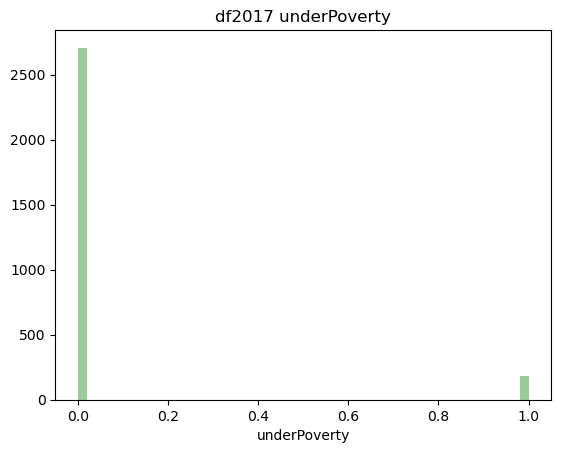

incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.110236
std         0.068827
min         0.000000
25%         0.062459
50%         0.096335
75%         0.138707
max         0.550931
Name: incomeBelowPovertyLevelProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------


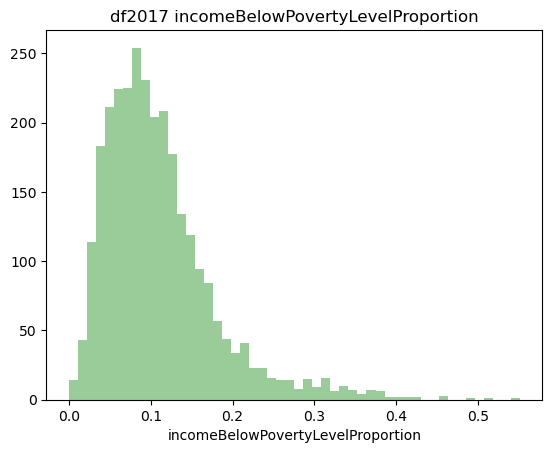

incomePerCapita
----------------------------------------------------------------------------
count      2887.000000
mean      31806.040873
std       14131.060441
min        4284.000000
25%       24210.500000
50%       28112.000000
75%       35076.000000
max      153897.000000
Name: incomePerCapita, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomePerCapita
----------------------------------------------------------------------------


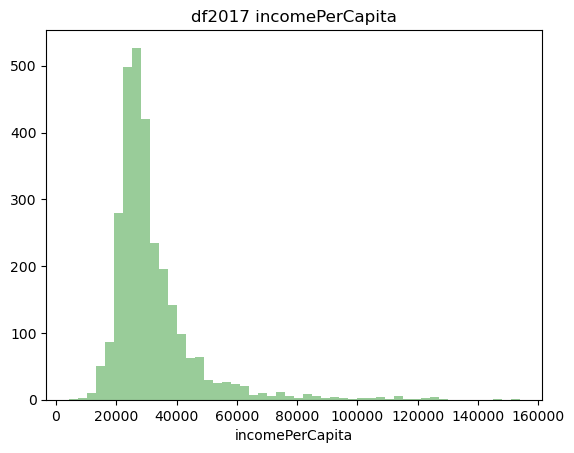

incomeGiniIndex
----------------------------------------------------------------------------
count    2887.000000
mean        0.419691
std         0.056284
min         0.185600
25%         0.383850
50%         0.414500
75%         0.451350
max         0.666300
Name: incomeGiniIndex, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeGiniIndex
----------------------------------------------------------------------------


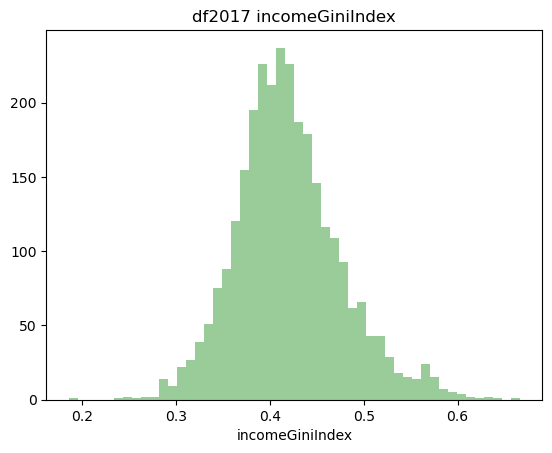

popDensity
----------------------------------------------------------------------------
count      2887.000000
mean       4033.800947
std       13545.365055
min           0.789848
25%          67.779115
50%         256.493800
75%        1727.167500
max      159438.900000
Name: popDensity, dtype: float64 
----------------------------------------------------------------------------
Distribution of popDensity
----------------------------------------------------------------------------


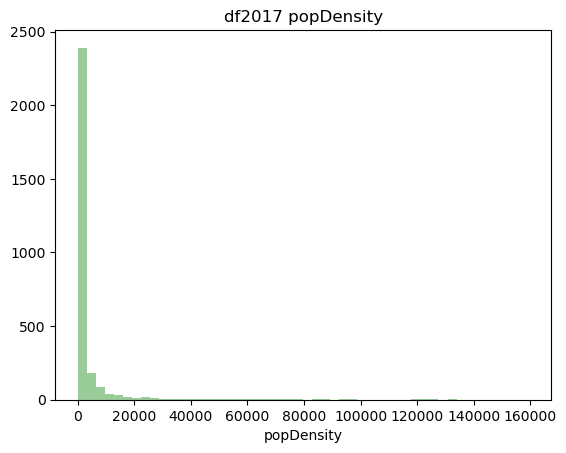

whiteMajority
----------------------------------------------------------------------------
count    2887.000000
mean        0.867541
std         0.189170
min         0.021461
25%         0.844740
50%         0.946746
75%         0.977980
max         1.000000
Name: whiteMajority, dtype: float64 
----------------------------------------------------------------------------
Distribution of whiteMajority
----------------------------------------------------------------------------


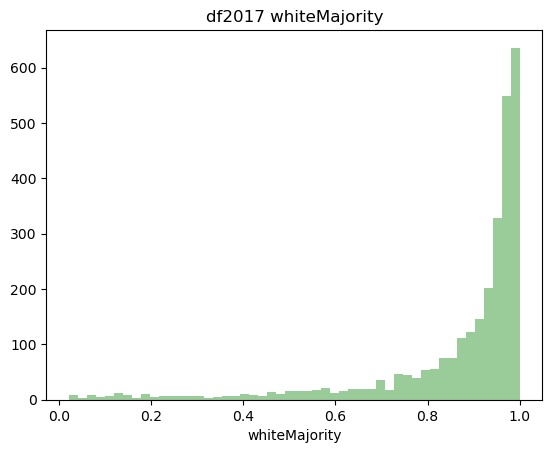

eduHsOrLessProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.107979
std         0.065779
min         0.000000
25%         0.063071
50%         0.096033
75%         0.135182
max         0.535537
Name: eduHsOrLessProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsOrLessProportion
----------------------------------------------------------------------------


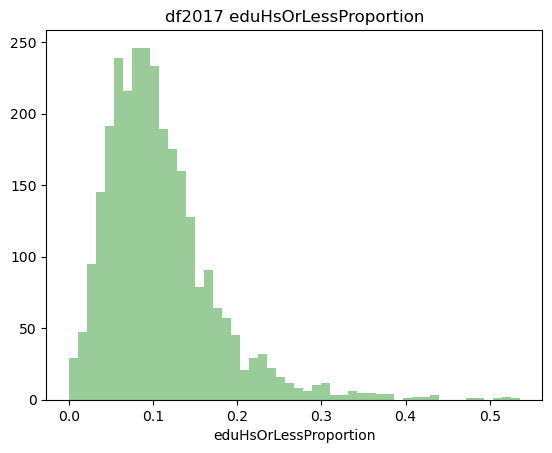

eduHsProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.625337
std         0.139577
min         0.080946
25%         0.557812
50%         0.660330
75%         0.723109
max         0.981221
Name: eduHsProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsProportion
----------------------------------------------------------------------------


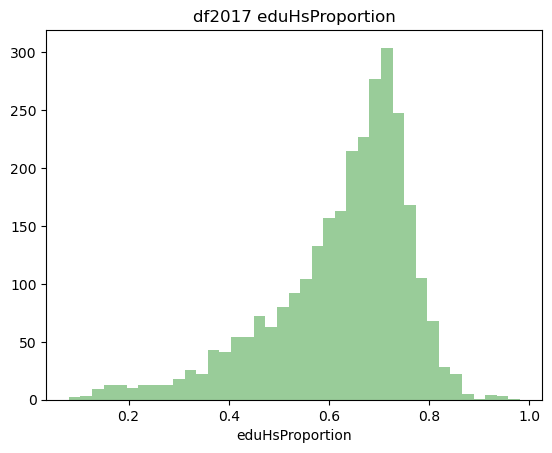

eduBachOrBetterProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.266684
std         0.159757
min         0.000000
25%         0.153152
50%         0.220880
75%         0.337357
max         0.904940
Name: eduBachOrBetterProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduBachOrBetterProportion
----------------------------------------------------------------------------


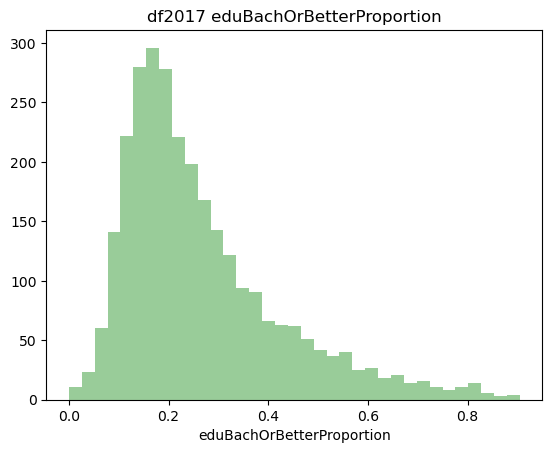

eduEnrollmentProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.226644
std         0.062902
min         0.000000
25%         0.191800
50%         0.222086
75%         0.254502
max         0.920959
Name: eduEnrollmentProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduEnrollmentProportion
----------------------------------------------------------------------------


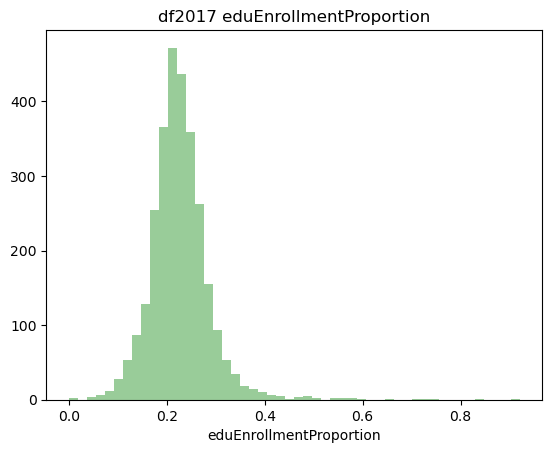

eduDropoutProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.049455
std         0.095458
min         0.000000
25%         0.000000
50%         0.013118
75%         0.057127
max         1.000000
Name: eduDropoutProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduDropoutProportion
----------------------------------------------------------------------------


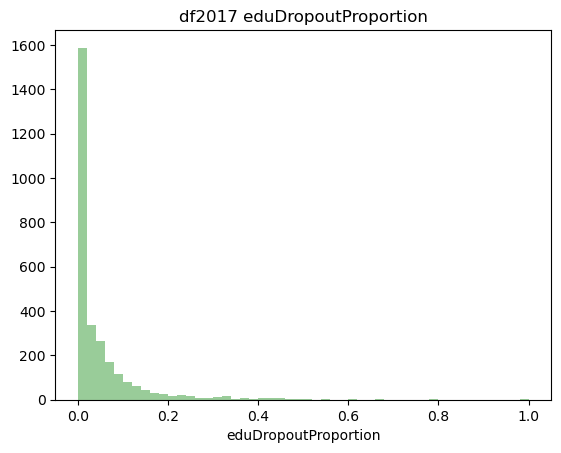

employedProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.937065
std         0.035178
min         0.700344
25%         0.922913
50%         0.943403
75%         0.959629
max         1.000000
Name: employedProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedProportion
----------------------------------------------------------------------------


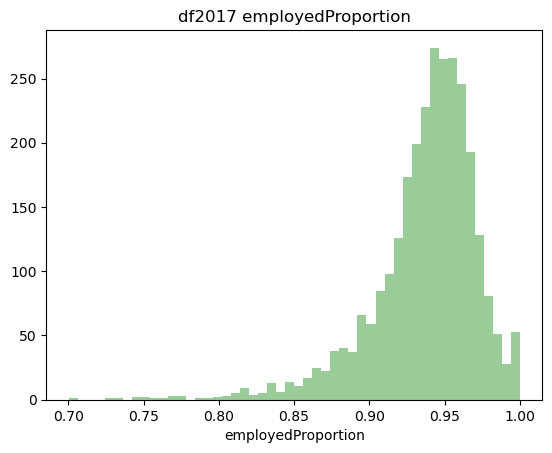

employedPvtSecProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.654975
std         0.093326
min         0.273684
25%         0.603405
50%         0.665854
75%         0.717531
max         1.000000
Name: employedPvtSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtSecProportion
----------------------------------------------------------------------------


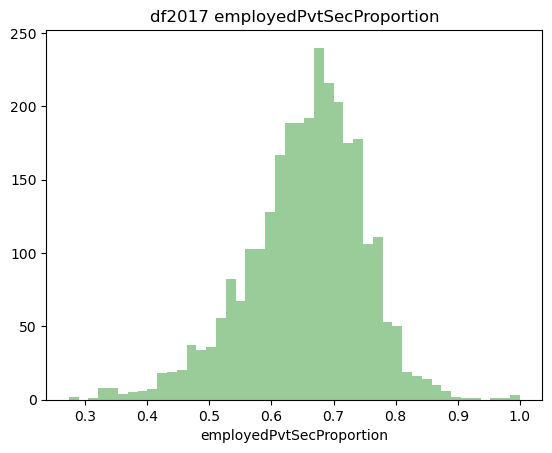

employedPubSecProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.144386
std         0.067587
min         0.000000
25%         0.096608
50%         0.133292
75%         0.180583
max         0.546512
Name: employedPubSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPubSecProportion
----------------------------------------------------------------------------


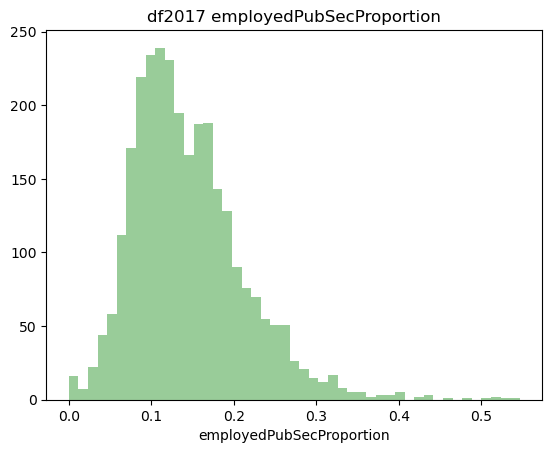

employedSelfEmpProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.096584
std         0.051525
min         0.000000
25%         0.063177
50%         0.086957
75%         0.119232
max         0.469663
Name: employedSelfEmpProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedSelfEmpProportion
----------------------------------------------------------------------------


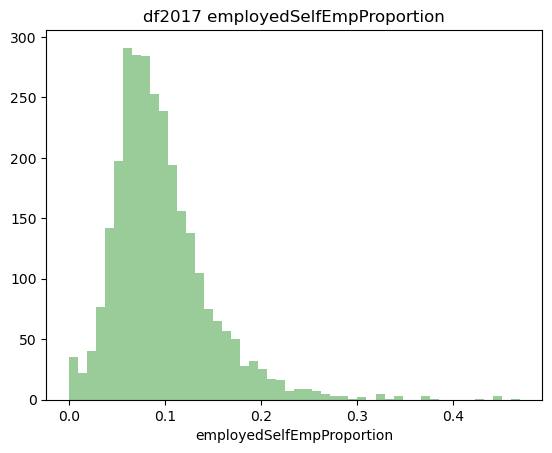

employedPvtNonProProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.101942
std         0.045492
min         0.000000
25%         0.073159
50%         0.096285
75%         0.124543
max         0.411058
Name: employedPvtNonProProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtNonProProportion
----------------------------------------------------------------------------


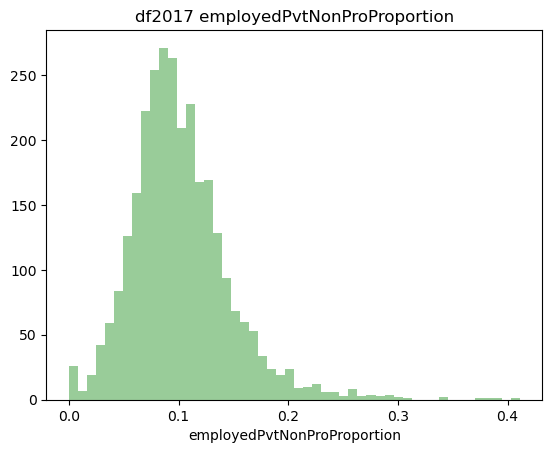

employedUnpaidFamProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.002113
std         0.005762
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002008
max         0.123853
Name: employedUnpaidFamProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedUnpaidFamProportion
----------------------------------------------------------------------------


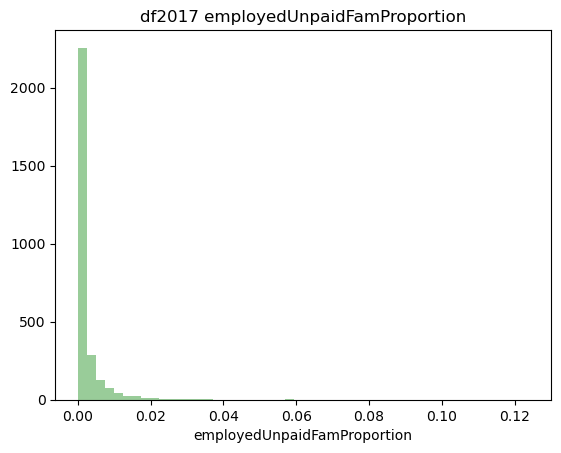

insuredProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.928316
std         0.052875
min         0.366816
25%         0.913487
50%         0.939296
75%         0.958962
max         1.000000
Name: insuredProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of insuredProportion
----------------------------------------------------------------------------


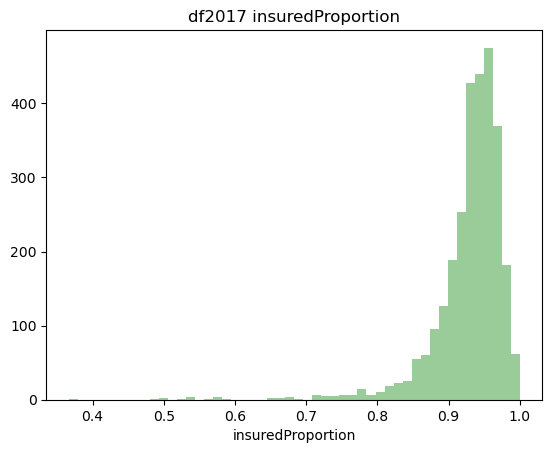

housingRentMoreThan30pcProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.408847
std         0.152616
min         0.000000
25%         0.316304
50%         0.415188
75%         0.504704
max         1.000000
Name: housingRentMoreThan30pcProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingRentMoreThan30pcProportion
----------------------------------------------------------------------------


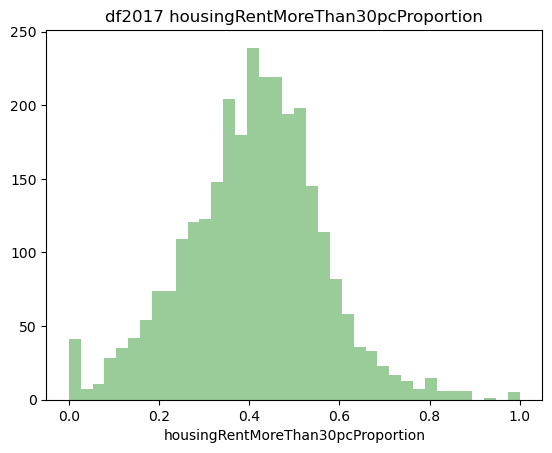

housingMedianValue
----------------------------------------------------------------------------
count    2.887000e+03
mean     2.170859e+05
std      1.992003e+05
min      2.230000e+04
25%      1.066500e+05
50%      1.544000e+05
75%      2.390000e+05
max      2.000001e+06
Name: housingMedianValue, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianValue
----------------------------------------------------------------------------


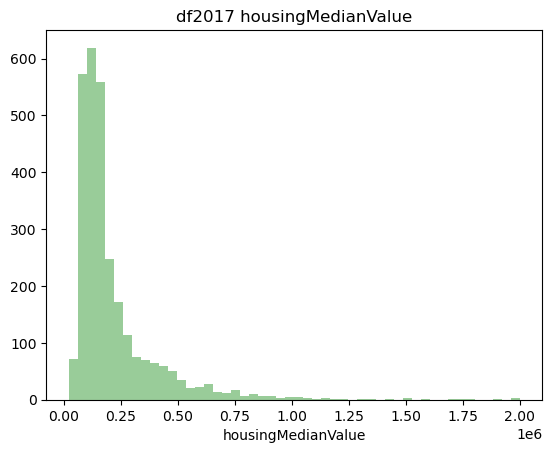

housingMedianGrossRent
----------------------------------------------------------------------------
count    2887.000000
mean      950.688950
std       403.966092
min       234.000000
25%       688.000000
50%       821.000000
75%      1087.500000
max      3501.000000
Name: housingMedianGrossRent, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianGrossRent
----------------------------------------------------------------------------


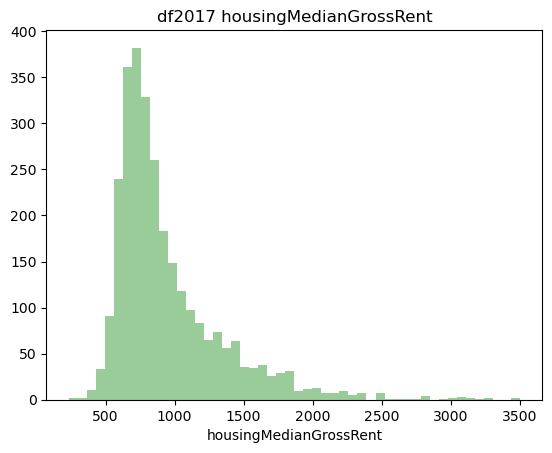

Description of columns for df2018
underPoverty
----------------------------------------------------------------------------
count    2882.000000
mean        0.058987
std         0.235641
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: underPoverty, dtype: float64 
----------------------------------------------------------------------------
Distribution of underPoverty
----------------------------------------------------------------------------


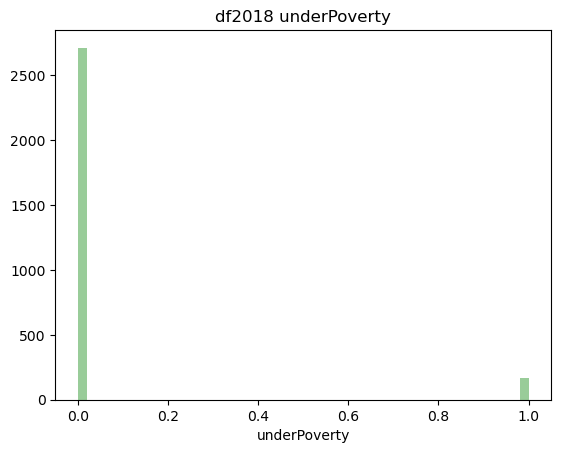

incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.108513
std         0.068869
min         0.000000
25%         0.060744
50%         0.095013
75%         0.138002
max         0.517228
Name: incomeBelowPovertyLevelProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------


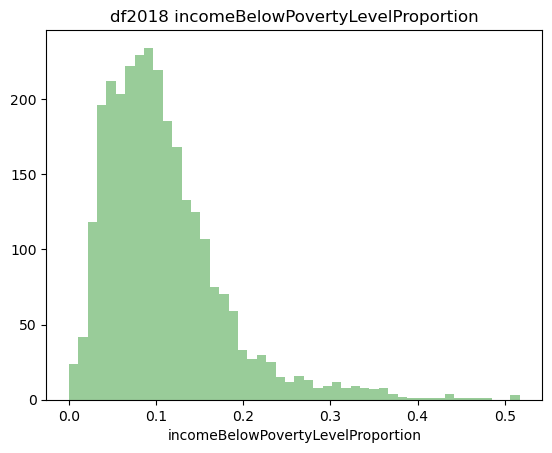

incomePerCapita
----------------------------------------------------------------------------
count      2882.000000
mean      33149.148855
std       14654.195627
min        4363.000000
25%       25158.000000
50%       29307.500000
75%       36381.500000
max      147547.000000
Name: incomePerCapita, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomePerCapita
----------------------------------------------------------------------------


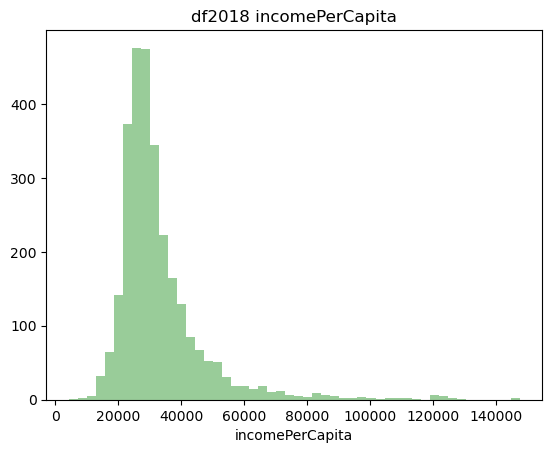

incomeGiniIndex
----------------------------------------------------------------------------
count    2882.000000
mean        0.420437
std         0.057318
min         0.148100
25%         0.384500
50%         0.416100
75%         0.450975
max         0.744000
Name: incomeGiniIndex, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeGiniIndex
----------------------------------------------------------------------------


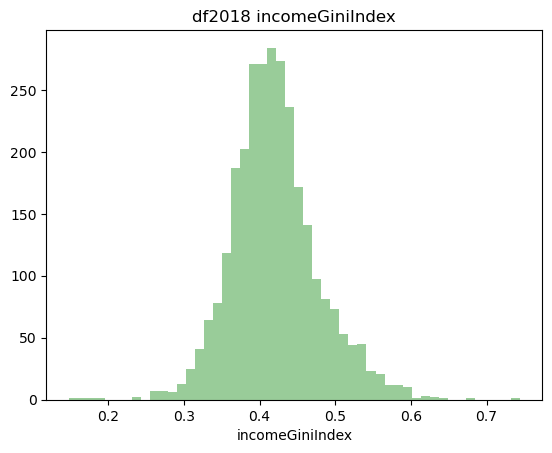

popDensity
----------------------------------------------------------------------------
count      2882.000000
mean       3989.496154
std       13343.555170
min           0.937378
25%          67.576835
50%         259.773100
75%        1727.251750
max      152562.200000
Name: popDensity, dtype: float64 
----------------------------------------------------------------------------
Distribution of popDensity
----------------------------------------------------------------------------


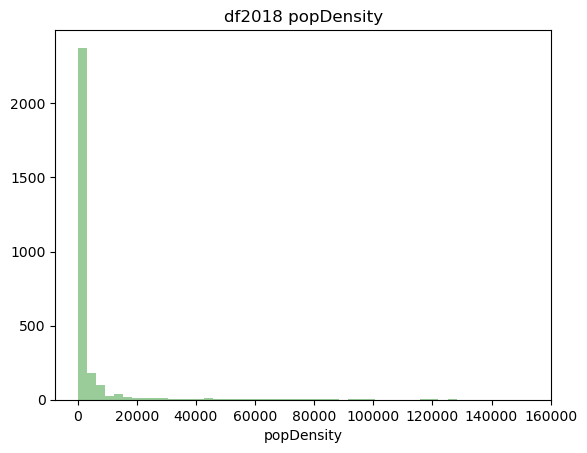

whiteMajority
----------------------------------------------------------------------------
count    2882.000000
mean        0.865820
std         0.189781
min         0.017646
25%         0.843025
50%         0.944096
75%         0.977290
max         1.000000
Name: whiteMajority, dtype: float64 
----------------------------------------------------------------------------
Distribution of whiteMajority
----------------------------------------------------------------------------


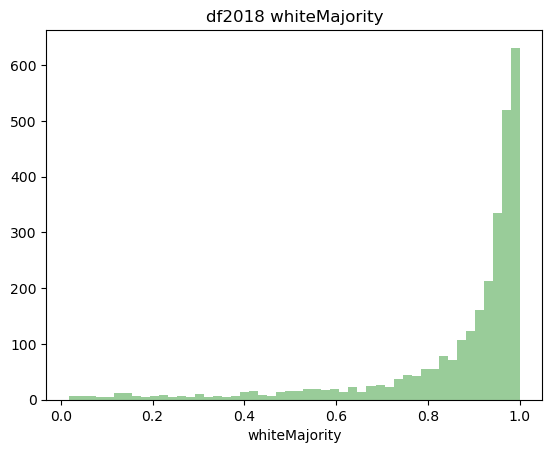

eduHsOrLessProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.104780
std         0.064802
min         0.000000
25%         0.061118
50%         0.092945
75%         0.131633
max         0.631382
Name: eduHsOrLessProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsOrLessProportion
----------------------------------------------------------------------------


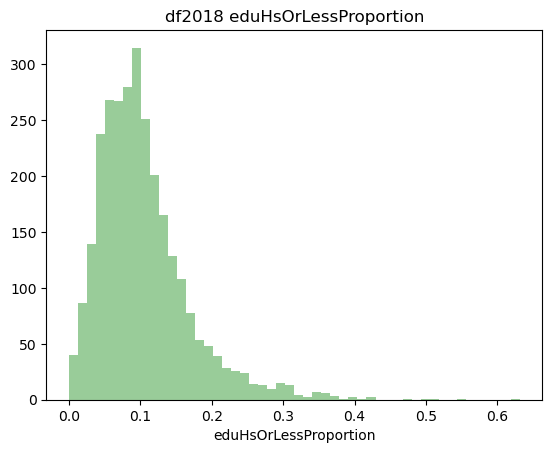

eduHsProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.622649
std         0.140725
min         0.084806
25%         0.551908
50%         0.659478
75%         0.721097
max         0.941799
Name: eduHsProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsProportion
----------------------------------------------------------------------------


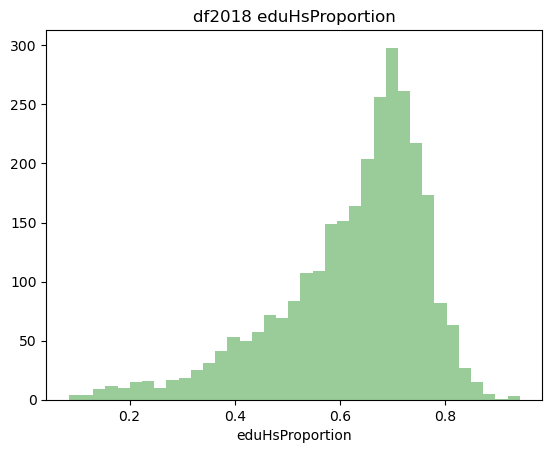

eduBachOrBetterProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.272572
std         0.160920
min         0.000000
25%         0.156296
50%         0.227601
75%         0.349211
max         0.904201
Name: eduBachOrBetterProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduBachOrBetterProportion
----------------------------------------------------------------------------


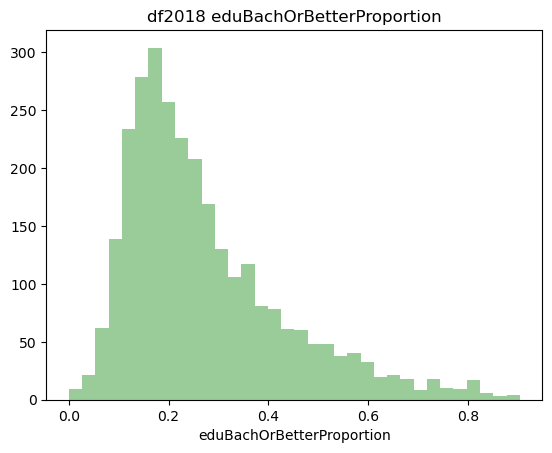

eduEnrollmentProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.224040
std         0.062560
min         0.000000
25%         0.190690
50%         0.220005
75%         0.251602
max         0.918690
Name: eduEnrollmentProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduEnrollmentProportion
----------------------------------------------------------------------------


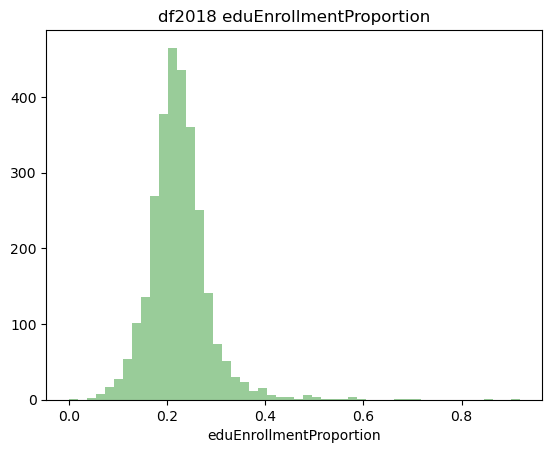

eduDropoutProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.050454
std         0.098145
min         0.000000
25%         0.000000
50%         0.012549
75%         0.058224
max         1.000000
Name: eduDropoutProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduDropoutProportion
----------------------------------------------------------------------------


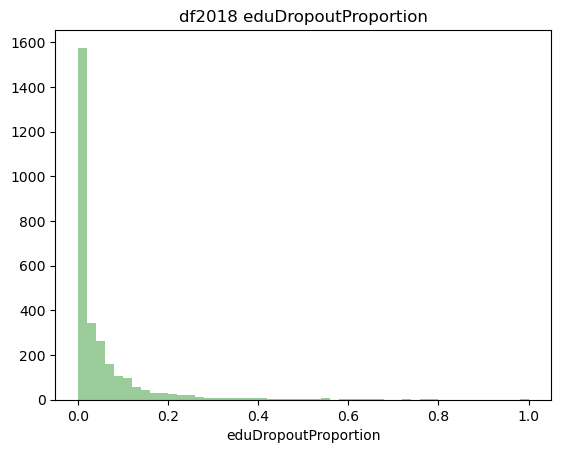

employedProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.943871
std         0.032340
min         0.724719
25%         0.930123
50%         0.949959
75%         0.964779
max         1.000000
Name: employedProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedProportion
----------------------------------------------------------------------------


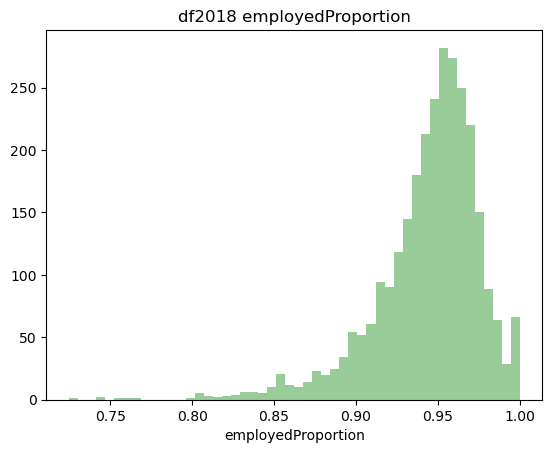

employedPvtSecProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.655063
std         0.092718
min         0.230769
25%         0.602629
50%         0.665298
75%         0.717955
max         0.944853
Name: employedPvtSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtSecProportion
----------------------------------------------------------------------------


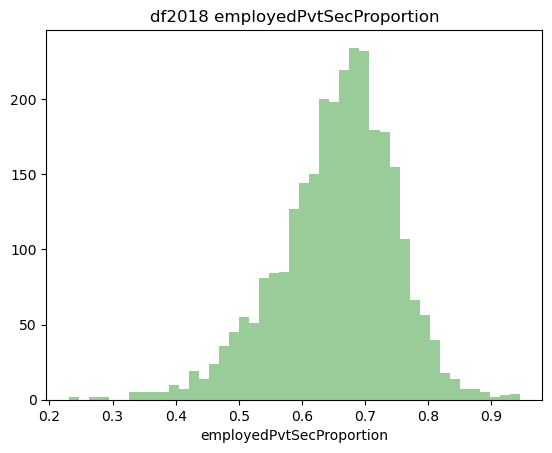

employedPubSecProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.143525
std         0.066799
min         0.000000
25%         0.096187
50%         0.133103
75%         0.179972
max         0.551440
Name: employedPubSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPubSecProportion
----------------------------------------------------------------------------


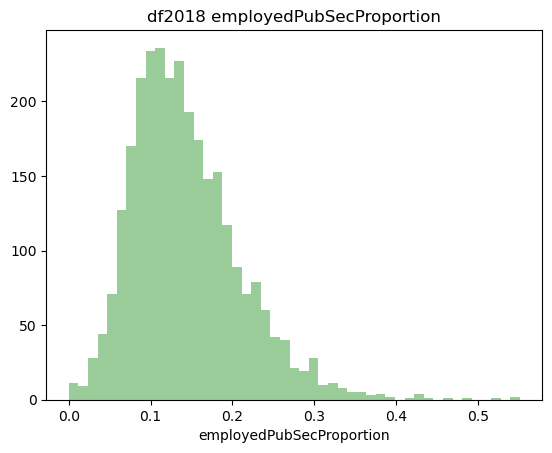

employedSelfEmpProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.096985
std         0.051924
min         0.000000
25%         0.063260
50%         0.086382
75%         0.119201
max         0.455285
Name: employedSelfEmpProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedSelfEmpProportion
----------------------------------------------------------------------------


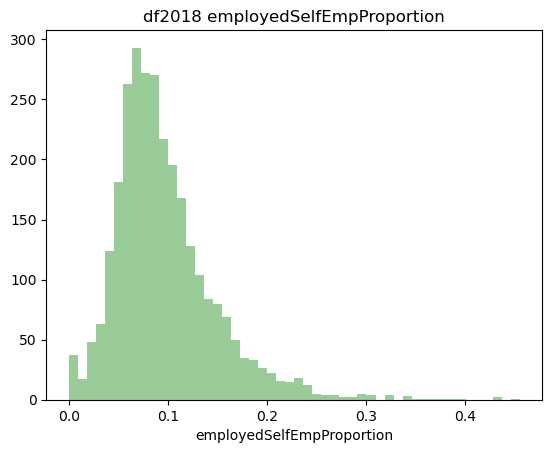

employedPvtNonProProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.102206
std         0.045332
min         0.000000
25%         0.073863
50%         0.096471
75%         0.124650
max         0.418719
Name: employedPvtNonProProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtNonProProportion
----------------------------------------------------------------------------


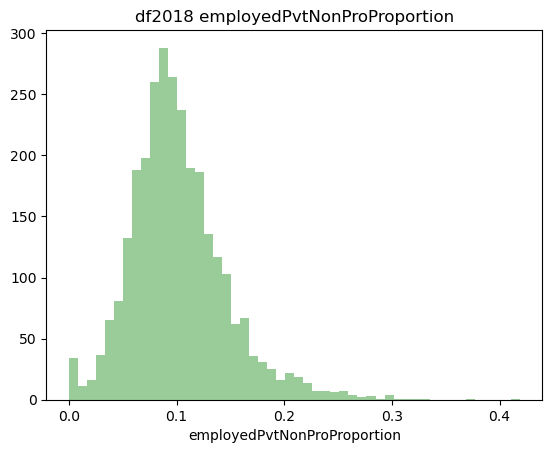

employedUnpaidFamProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.002221
std         0.006411
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002094
max         0.148936
Name: employedUnpaidFamProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedUnpaidFamProportion
----------------------------------------------------------------------------


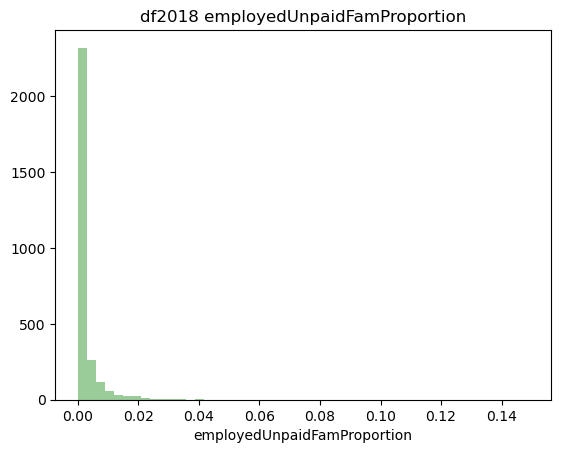

insuredProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.937934
std         0.051350
min         0.381228
25%         0.925304
50%         0.948882
75%         0.966641
max         1.000000
Name: insuredProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of insuredProportion
----------------------------------------------------------------------------


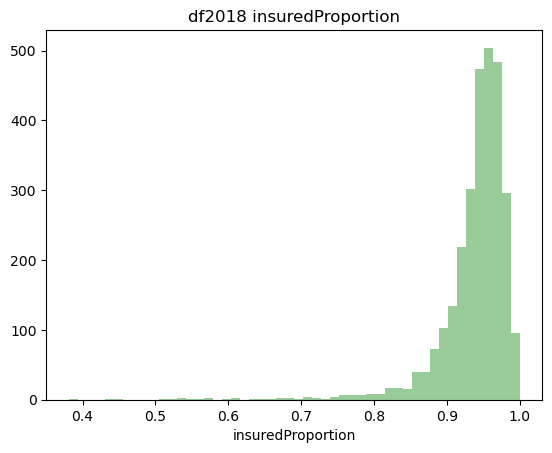

housingRentMoreThan30pcProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.404453
std         0.152075
min         0.000000
25%         0.313686
50%         0.413411
75%         0.501164
max         1.000000
Name: housingRentMoreThan30pcProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingRentMoreThan30pcProportion
----------------------------------------------------------------------------


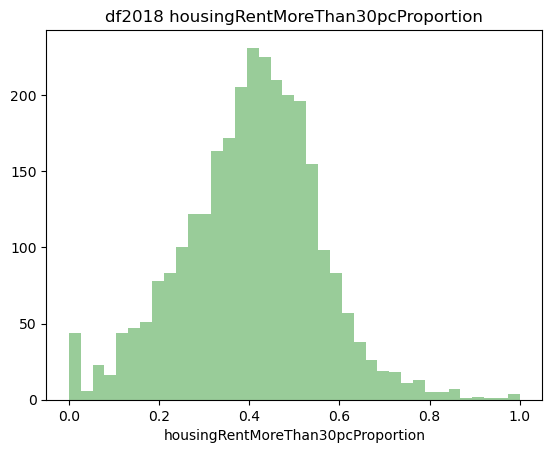

housingMedianValue
----------------------------------------------------------------------------
count    2.882000e+03
mean     2.230767e+05
std      2.047102e+05
min      2.600000e+04
25%      1.090000e+05
50%      1.568000e+05
75%      2.449500e+05
max      2.000001e+06
Name: housingMedianValue, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianValue
----------------------------------------------------------------------------


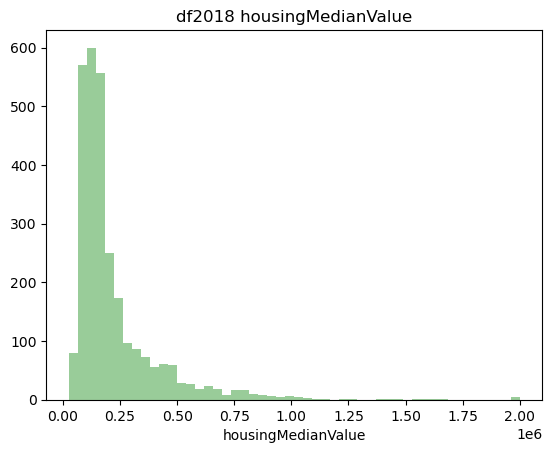

housingMedianGrossRent
----------------------------------------------------------------------------
count    2882.000000
mean      978.712353
std       419.524038
min       289.000000
25%       702.000000
50%       841.000000
75%      1120.000000
max      3501.000000
Name: housingMedianGrossRent, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianGrossRent
----------------------------------------------------------------------------


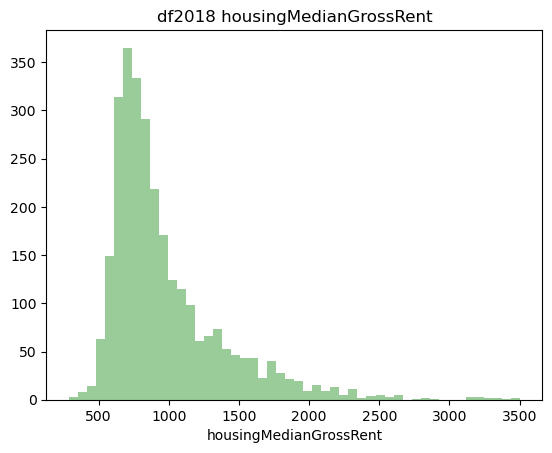

Description of columns for df2019
underPoverty
----------------------------------------------------------------------------
count    2856.000000
mean        0.059874
std         0.237295
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: underPoverty, dtype: float64 
----------------------------------------------------------------------------
Distribution of underPoverty
----------------------------------------------------------------------------


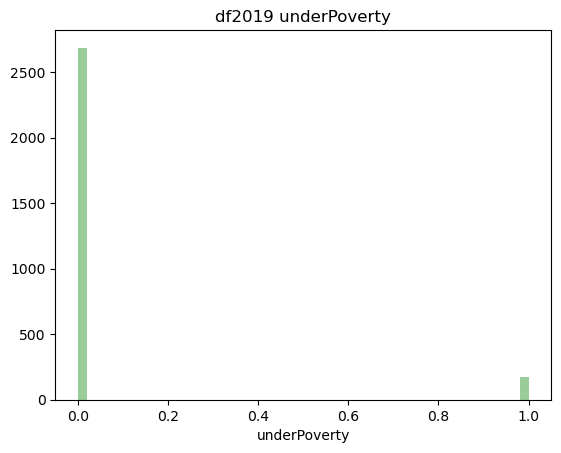

incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.105943
std         0.067413
min         0.000000
25%         0.059402
50%         0.092681
75%         0.134132
max         0.609756
Name: incomeBelowPovertyLevelProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------


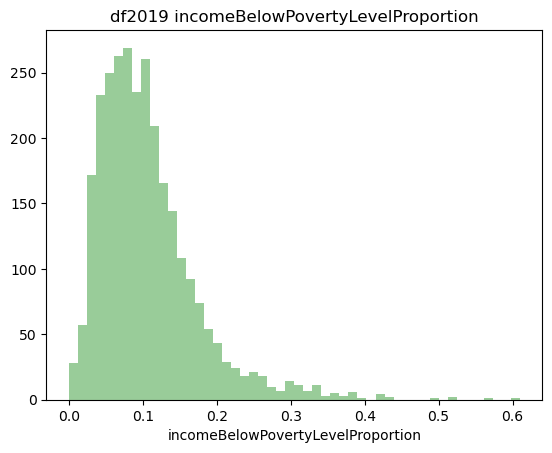

incomePerCapita
----------------------------------------------------------------------------
count      2856.000000
mean      34517.297619
std       15373.485946
min        4744.000000
25%       26022.000000
50%       30583.000000
75%       37985.250000
max      152846.000000
Name: incomePerCapita, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomePerCapita
----------------------------------------------------------------------------


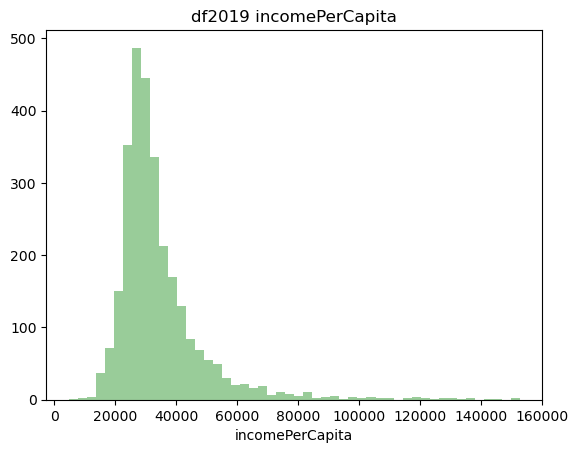

incomeGiniIndex
----------------------------------------------------------------------------
count    2856.000000
mean        0.421073
std         0.056863
min         0.170400
25%         0.385900
50%         0.416400
75%         0.453050
max         0.729100
Name: incomeGiniIndex, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeGiniIndex
----------------------------------------------------------------------------


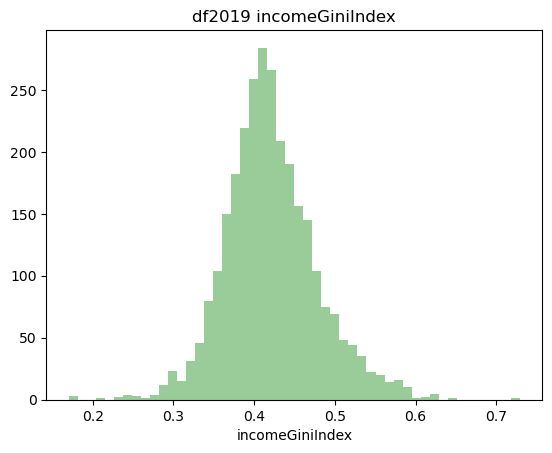

popDensity
----------------------------------------------------------------------------
count      2856.000000
mean       3996.209031
std       13271.132963
min           0.851130
25%          67.234912
50%         257.172300
75%        1756.211500
max      149289.800000
Name: popDensity, dtype: float64 
----------------------------------------------------------------------------
Distribution of popDensity
----------------------------------------------------------------------------


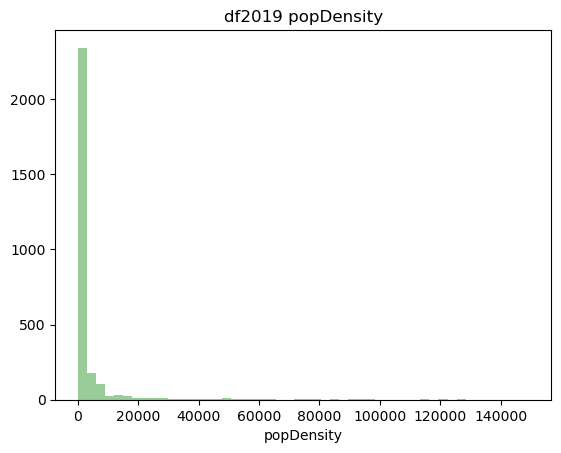

whiteMajority
----------------------------------------------------------------------------
count    2856.000000
mean        0.864107
std         0.189863
min         0.024178
25%         0.841947
50%         0.942168
75%         0.976889
max         1.000000
Name: whiteMajority, dtype: float64 
----------------------------------------------------------------------------
Distribution of whiteMajority
----------------------------------------------------------------------------


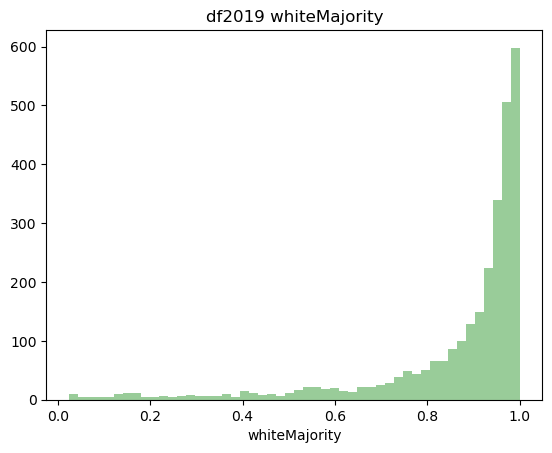

eduHsOrLessProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.102227
std         0.064064
min         0.000000
25%         0.058542
50%         0.089177
75%         0.129793
max         0.503417
Name: eduHsOrLessProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsOrLessProportion
----------------------------------------------------------------------------


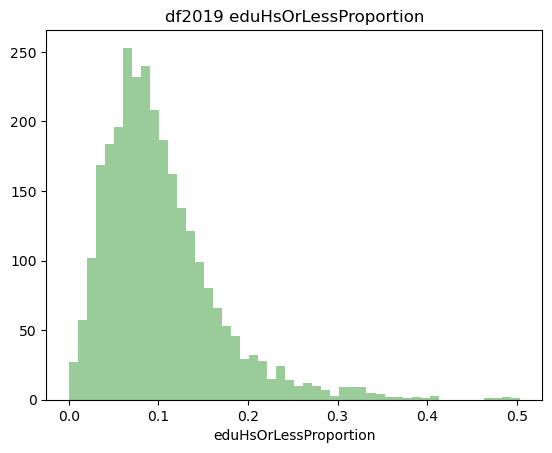

eduHsProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.619412
std         0.143231
min         0.070849
25%         0.546006
50%         0.653468
75%         0.720817
max         1.000000
Name: eduHsProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsProportion
----------------------------------------------------------------------------


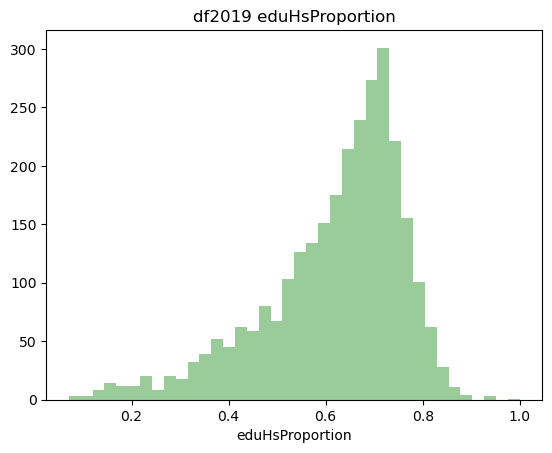

eduBachOrBetterProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.278361
std         0.162731
min         0.000000
25%         0.160146
50%         0.234329
75%         0.356162
max         0.918576
Name: eduBachOrBetterProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduBachOrBetterProportion
----------------------------------------------------------------------------


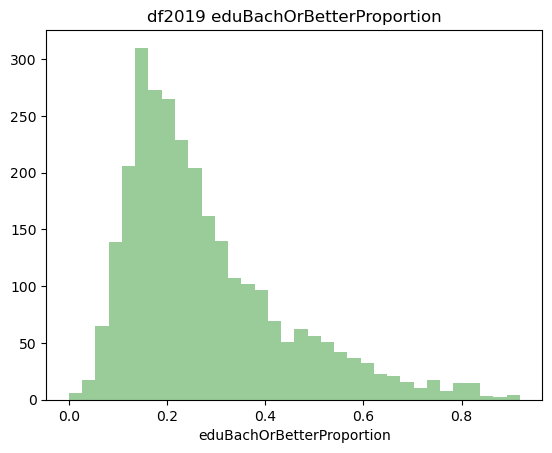

eduEnrollmentProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.221662
std         0.062408
min         0.000000
25%         0.187330
50%         0.217606
75%         0.250218
max         0.908617
Name: eduEnrollmentProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduEnrollmentProportion
----------------------------------------------------------------------------


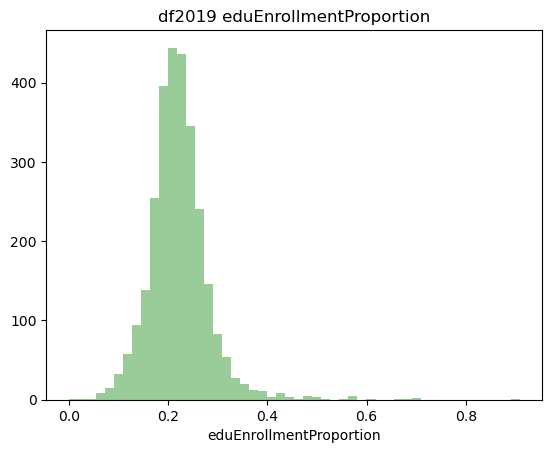

eduDropoutProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.051578
std         0.100601
min         0.000000
25%         0.000000
50%         0.011668
75%         0.059148
max         1.000000
Name: eduDropoutProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduDropoutProportion
----------------------------------------------------------------------------


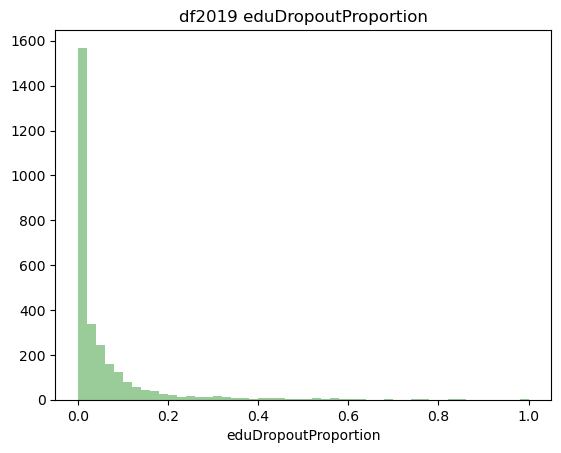

employedProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.948727
std         0.031007
min         0.648963
25%         0.936530
50%         0.954567
75%         0.968162
max         1.000000
Name: employedProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedProportion
----------------------------------------------------------------------------


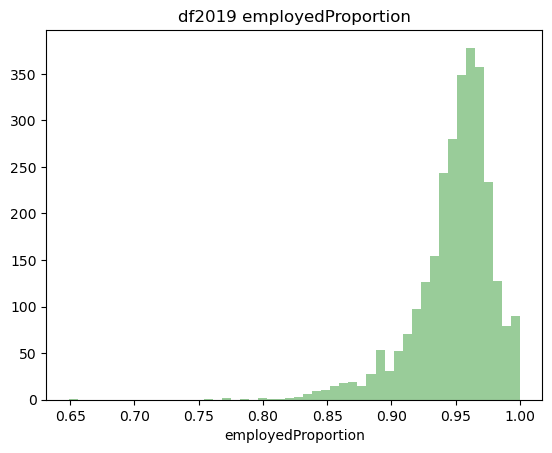

employedPvtSecProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.653154
std         0.092962
min         0.191489
25%         0.602458
50%         0.662736
75%         0.714632
max         0.951691
Name: employedPvtSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtSecProportion
----------------------------------------------------------------------------


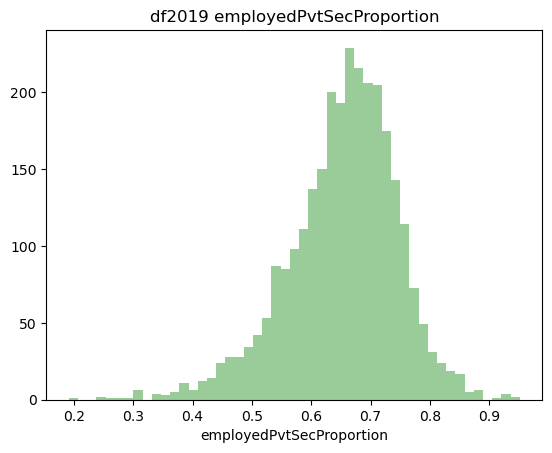

employedPubSecProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.144876
std         0.067670
min         0.000000
25%         0.096885
50%         0.134891
75%         0.180956
max         0.575064
Name: employedPubSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPubSecProportion
----------------------------------------------------------------------------


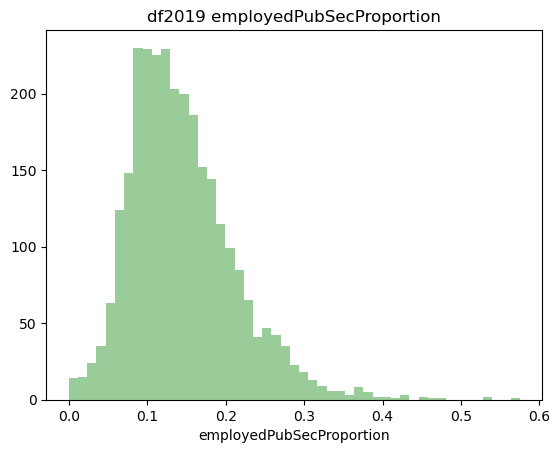

employedSelfEmpProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.096139
std         0.050625
min         0.000000
25%         0.063173
50%         0.086921
75%         0.117050
max         0.439320
Name: employedSelfEmpProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedSelfEmpProportion
----------------------------------------------------------------------------


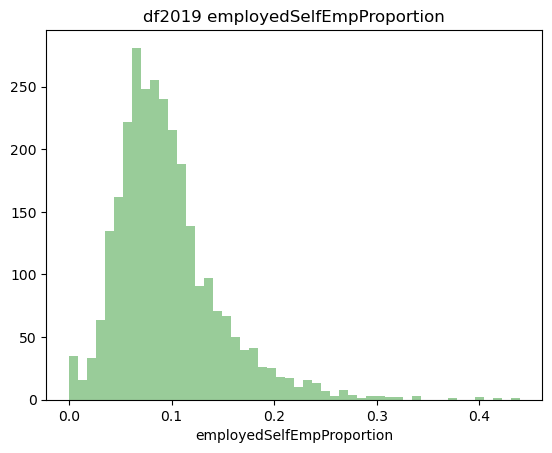

employedPvtNonProProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.103567
std         0.045999
min         0.000000
25%         0.074605
50%         0.097302
75%         0.125896
max         0.561856
Name: employedPvtNonProProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtNonProProportion
----------------------------------------------------------------------------


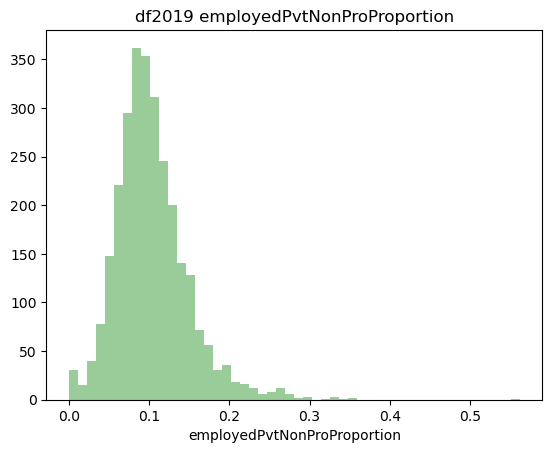

employedUnpaidFamProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.002264
std         0.006313
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002323
max         0.127273
Name: employedUnpaidFamProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedUnpaidFamProportion
----------------------------------------------------------------------------


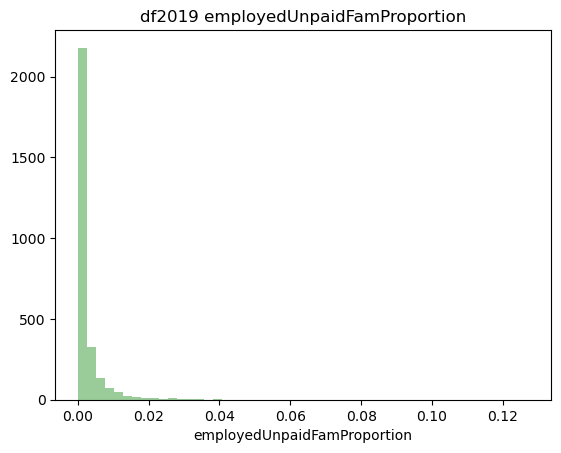

insuredProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.943066
std         0.051905
min         0.396632
25%         0.932719
50%         0.954917
75%         0.971130
max         1.000000
Name: insuredProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of insuredProportion
----------------------------------------------------------------------------


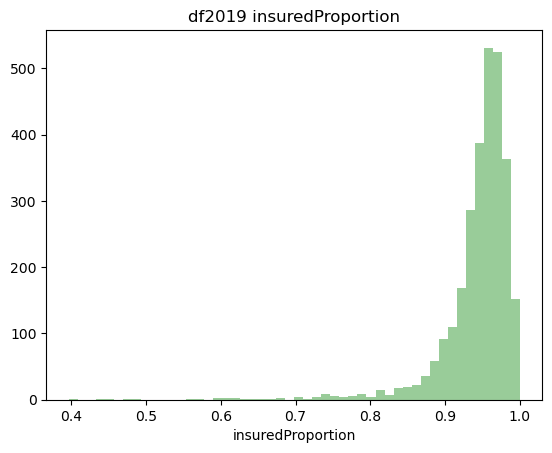

housingRentMoreThan30pcProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.400008
std         0.152443
min         0.000000
25%         0.308070
50%         0.407407
75%         0.498136
max         1.000000
Name: housingRentMoreThan30pcProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingRentMoreThan30pcProportion
----------------------------------------------------------------------------


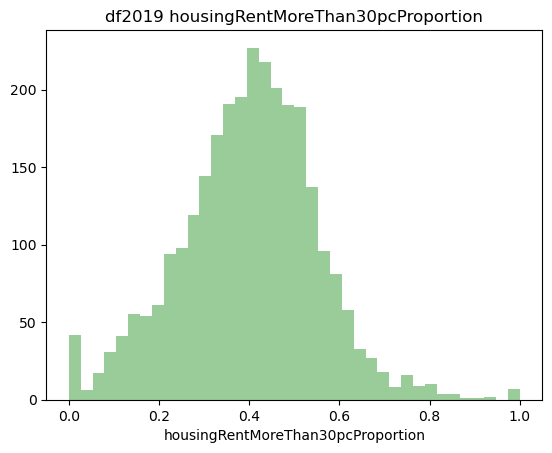

housingMedianValue
----------------------------------------------------------------------------
count    2.856000e+03
mean     2.303800e+05
std      2.127244e+05
min      2.720000e+04
25%      1.130000e+05
50%      1.600000e+05
75%      2.524000e+05
max      2.000001e+06
Name: housingMedianValue, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianValue
----------------------------------------------------------------------------


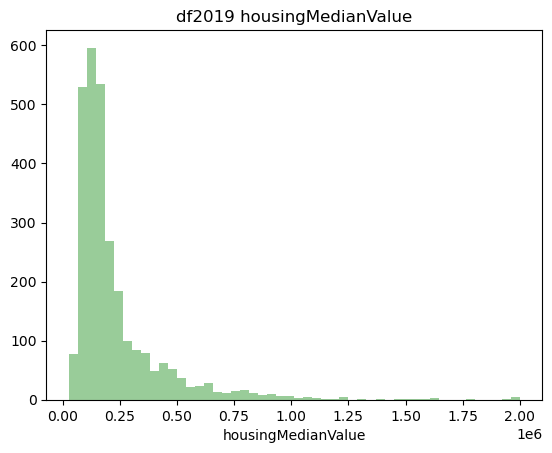

housingMedianGrossRent
----------------------------------------------------------------------------
count    2856.000000
mean     1001.792367
std       434.224649
min       323.000000
25%       718.000000
50%       856.000000
75%      1138.000000
max      3501.000000
Name: housingMedianGrossRent, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianGrossRent
----------------------------------------------------------------------------


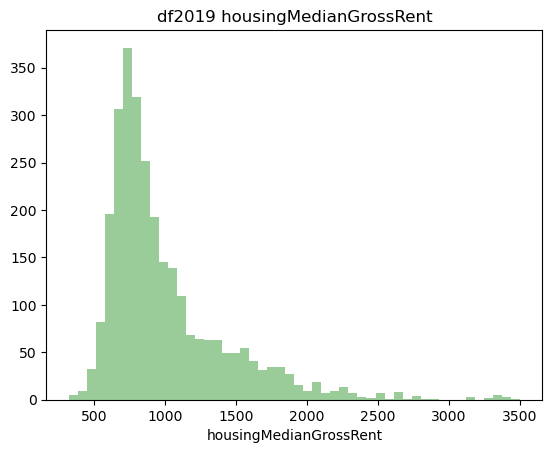

Description of columns for df2020
underPoverty
----------------------------------------------------------------------------
count    2811.000000
mean        0.055141
std         0.228295
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: underPoverty, dtype: float64 
----------------------------------------------------------------------------
Distribution of underPoverty
----------------------------------------------------------------------------


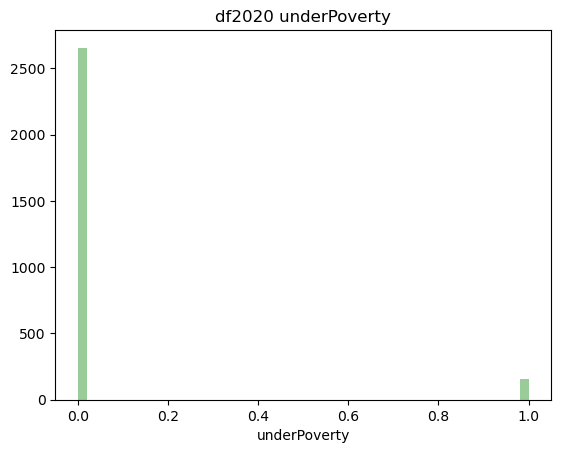

incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.103439
std         0.066428
min         0.000000
25%         0.057364
50%         0.089596
75%         0.132462
max         0.518965
Name: incomeBelowPovertyLevelProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------


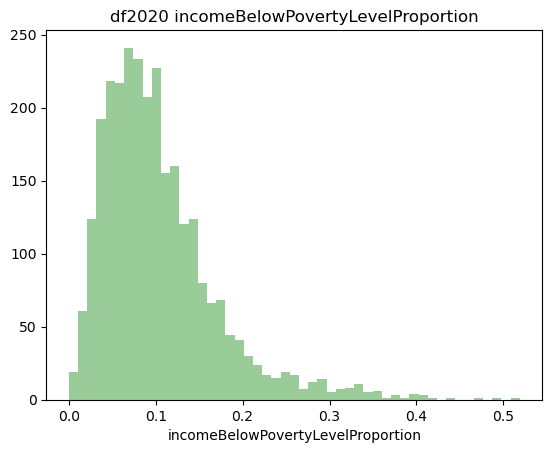

incomePerCapita
----------------------------------------------------------------------------
count      2811.000000
mean      35847.019210
std       16213.640132
min        4608.000000
25%       26882.500000
50%       31673.000000
75%       39416.000000
max      182463.000000
Name: incomePerCapita, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomePerCapita
----------------------------------------------------------------------------


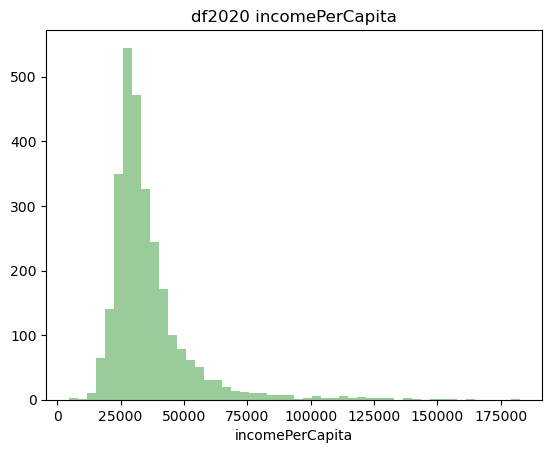

incomeGiniIndex
----------------------------------------------------------------------------
count    2811.000000
mean        0.420347
std         0.059651
min         0.091900
25%         0.382900
50%         0.415700
75%         0.453000
max         0.726300
Name: incomeGiniIndex, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeGiniIndex
----------------------------------------------------------------------------


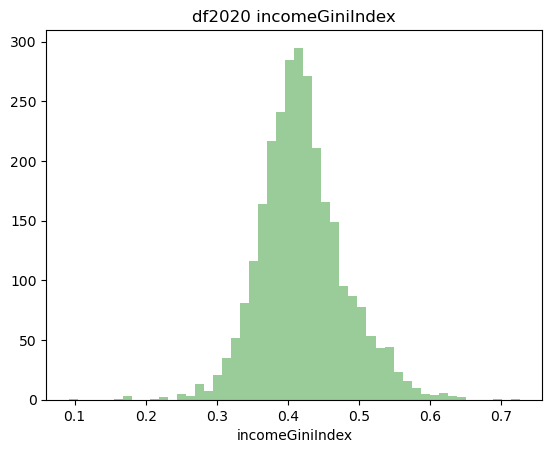

popDensity
----------------------------------------------------------------------------
count      2811.000000
mean       4063.336855
std       13387.458958
min           0.907872
25%          66.722730
50%         260.700700
75%        1793.080500
max      153099.800000
Name: popDensity, dtype: float64 
----------------------------------------------------------------------------
Distribution of popDensity
----------------------------------------------------------------------------


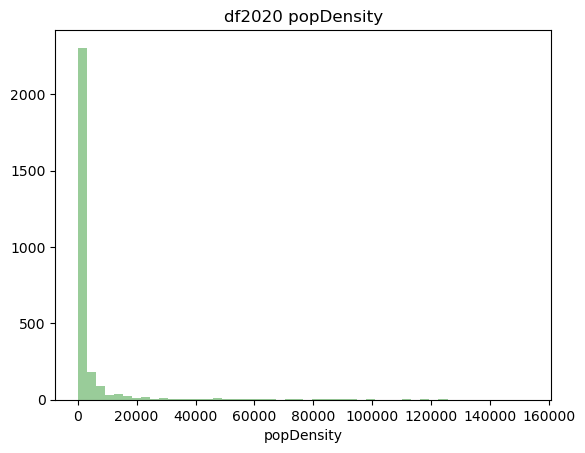

whiteMajority
----------------------------------------------------------------------------
count    2811.000000
mean        0.851557
std         0.193762
min         0.022483
25%         0.817987
50%         0.928994
75%         0.971399
max         1.000000
Name: whiteMajority, dtype: float64 
----------------------------------------------------------------------------
Distribution of whiteMajority
----------------------------------------------------------------------------


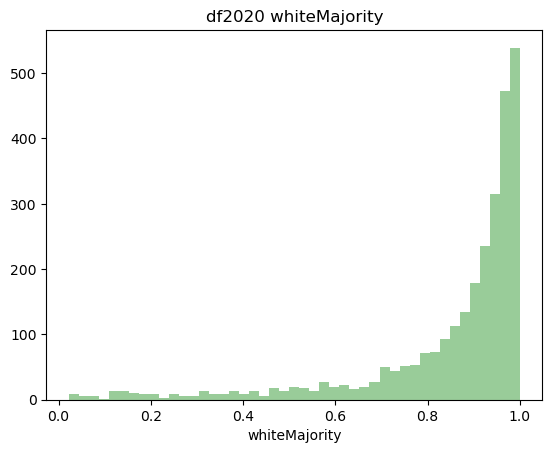

eduHsOrLessProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.098634
std         0.063781
min         0.000000
25%         0.055365
50%         0.085992
75%         0.124671
max         0.495264
Name: eduHsOrLessProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsOrLessProportion
----------------------------------------------------------------------------


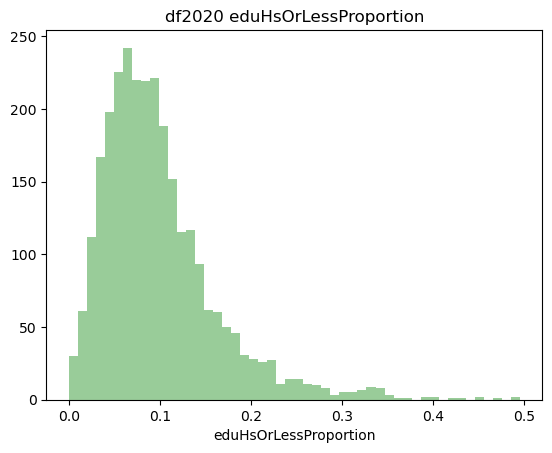

eduHsProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.614248
std         0.146517
min         0.055536
25%         0.540900
50%         0.647910
75%         0.717635
max         1.000000
Name: eduHsProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsProportion
----------------------------------------------------------------------------


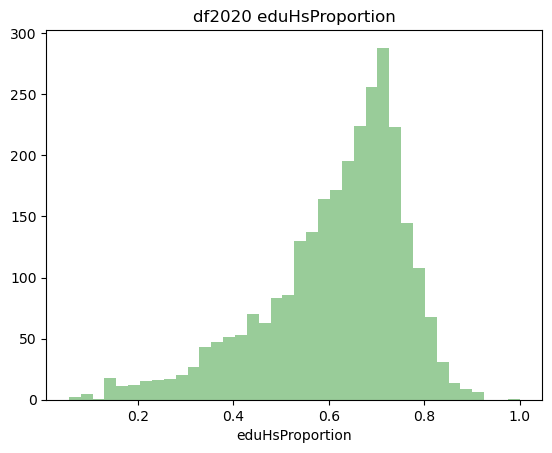

eduBachOrBetterProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.287118
std         0.165227
min         0.000000
25%         0.167603
50%         0.241803
75%         0.366756
max         0.939979
Name: eduBachOrBetterProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduBachOrBetterProportion
----------------------------------------------------------------------------


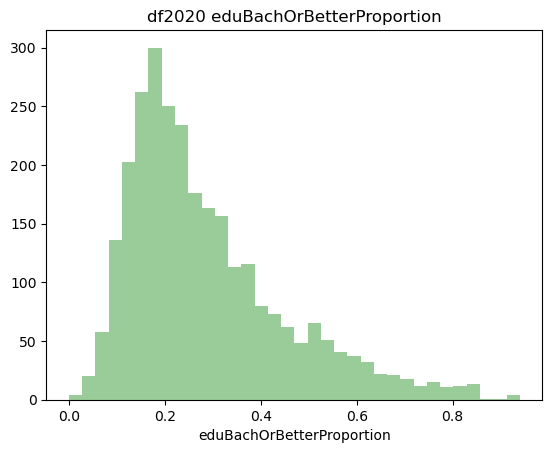

eduEnrollmentProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.218654
std         0.064701
min         0.031315
25%         0.182139
50%         0.213914
75%         0.248895
max         0.903481
Name: eduEnrollmentProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduEnrollmentProportion
----------------------------------------------------------------------------


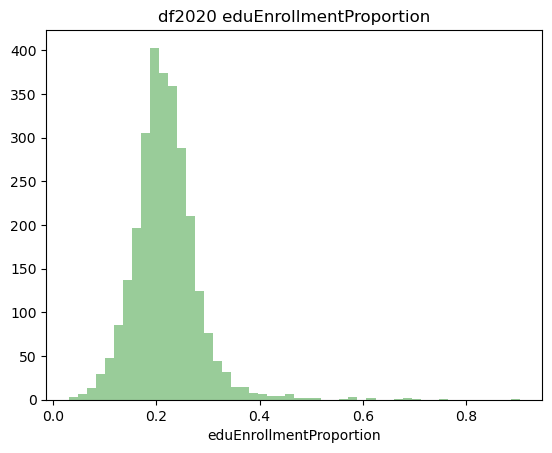

eduDropoutProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.056401
std         0.113576
min         0.000000
25%         0.000000
50%         0.011923
75%         0.061777
max         1.000000
Name: eduDropoutProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduDropoutProportion
----------------------------------------------------------------------------


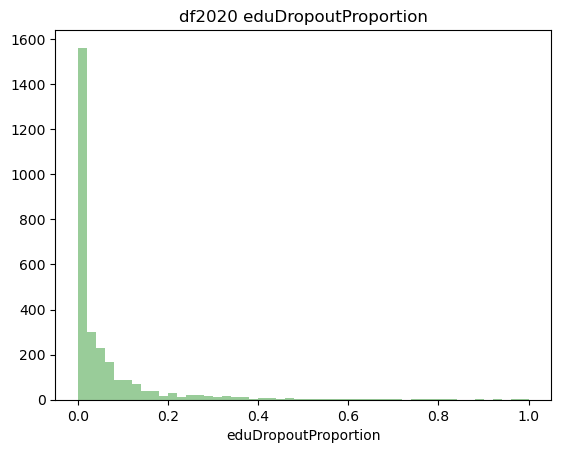

employedProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.947891
std         0.033163
min         0.703980
25%         0.934521
50%         0.953821
75%         0.968725
max         1.000000
Name: employedProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedProportion
----------------------------------------------------------------------------


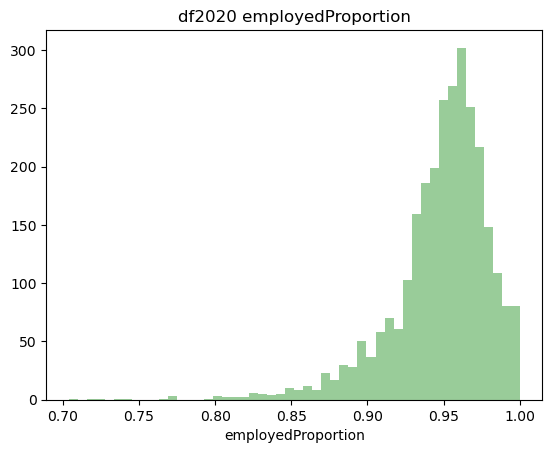

employedPvtSecProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.645754
std         0.095061
min         0.247368
25%         0.592943
50%         0.653876
75%         0.709276
max         0.939326
Name: employedPvtSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtSecProportion
----------------------------------------------------------------------------


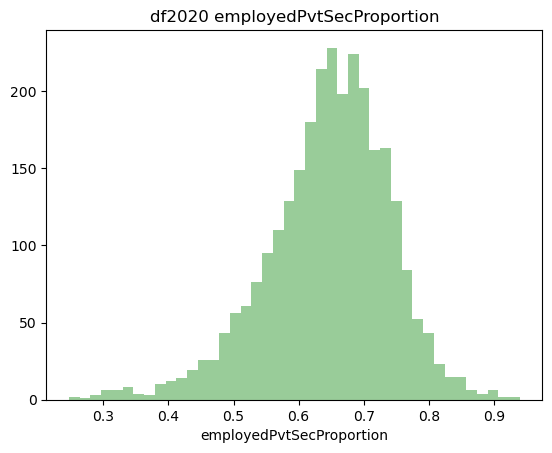

employedPubSecProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.148218
std         0.069876
min         0.000000
25%         0.098230
50%         0.136931
75%         0.186587
max         0.573625
Name: employedPubSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPubSecProportion
----------------------------------------------------------------------------


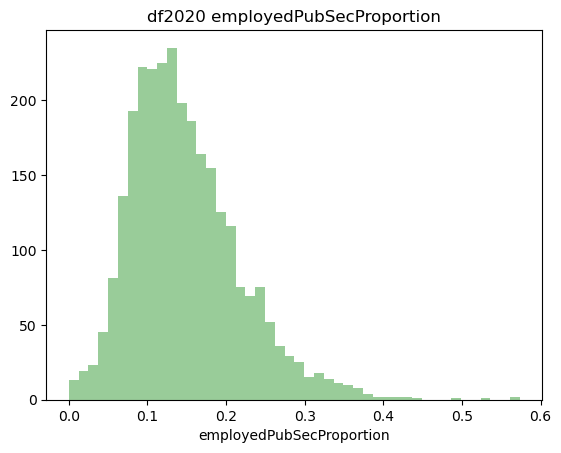

employedSelfEmpProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.096966
std         0.052152
min         0.000000
25%         0.063143
50%         0.087248
75%         0.120017
max         0.539952
Name: employedSelfEmpProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedSelfEmpProportion
----------------------------------------------------------------------------


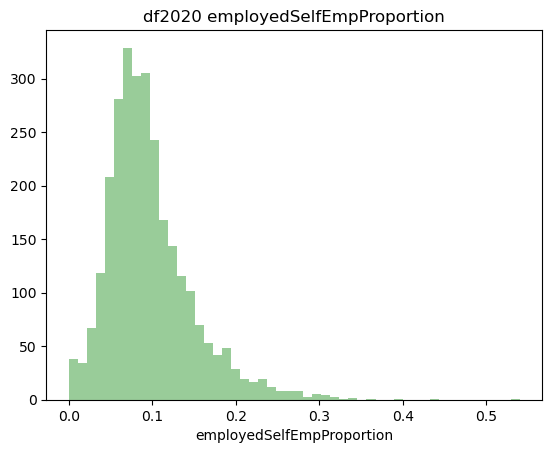

employedPvtNonProProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.106722
std         0.049735
min         0.000000
25%         0.075805
50%         0.100162
75%         0.129992
max         0.594737
Name: employedPvtNonProProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtNonProProportion
----------------------------------------------------------------------------


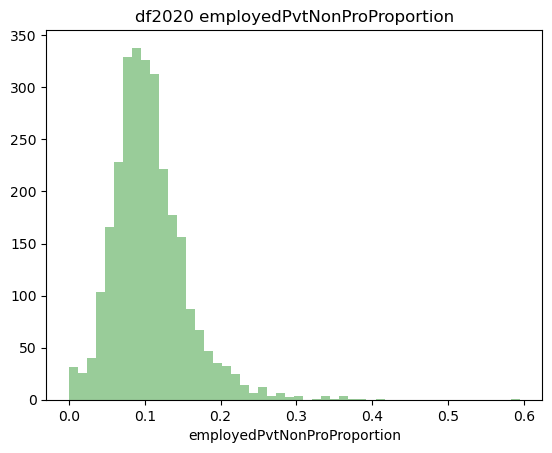

employedUnpaidFamProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.002341
std         0.006840
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002129
max         0.114190
Name: employedUnpaidFamProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedUnpaidFamProportion
----------------------------------------------------------------------------


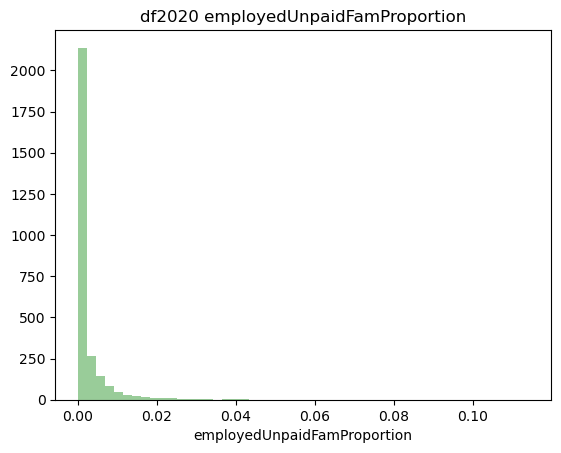

insuredProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.943974
std         0.054232
min         0.423913
25%         0.932711
50%         0.956721
75%         0.973095
max         1.000000
Name: insuredProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of insuredProportion
----------------------------------------------------------------------------


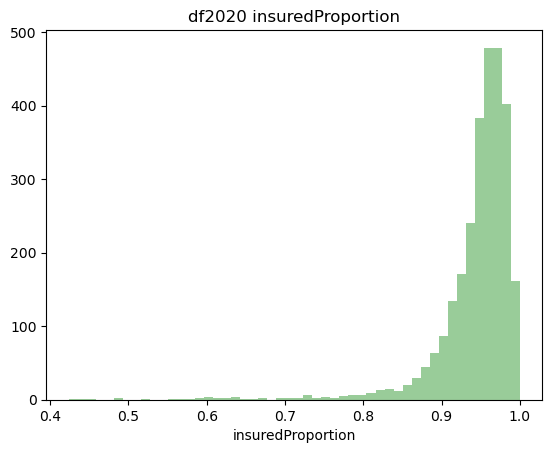

housingRentMoreThan30pcProportion
----------------------------------------------------------------------------
count    2811.000000
mean        0.390722
std         0.157417
min         0.000000
25%         0.291667
50%         0.401786
75%         0.495461
max         1.000000
Name: housingRentMoreThan30pcProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingRentMoreThan30pcProportion
----------------------------------------------------------------------------


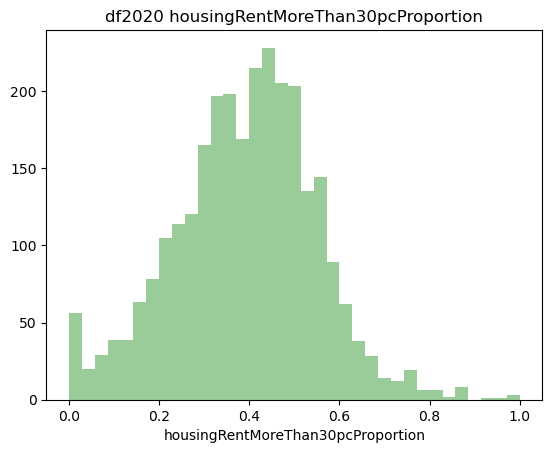

housingMedianValue
----------------------------------------------------------------------------
count    2.811000e+03
mean     2.392085e+05
std      2.215066e+05
min      9.999000e+03
25%      1.178000e+05
50%      1.652000e+05
75%      2.603000e+05
max      2.000001e+06
Name: housingMedianValue, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianValue
----------------------------------------------------------------------------


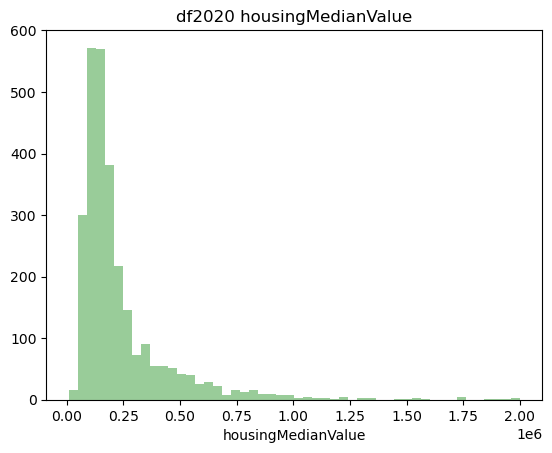

housingMedianGrossRent
----------------------------------------------------------------------------
count    2811.000000
mean     1022.822483
std       453.334879
min       225.000000
25%       725.000000
50%       872.000000
75%      1165.500000
max      3501.000000
Name: housingMedianGrossRent, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianGrossRent
----------------------------------------------------------------------------


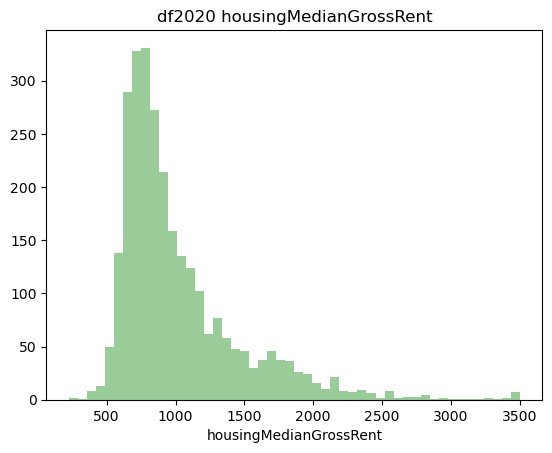

Description of columns for df2021
underPoverty
----------------------------------------------------------------------------
count    2762.000000
mean        0.051412
std         0.220877
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: underPoverty, dtype: float64 
----------------------------------------------------------------------------
Distribution of underPoverty
----------------------------------------------------------------------------


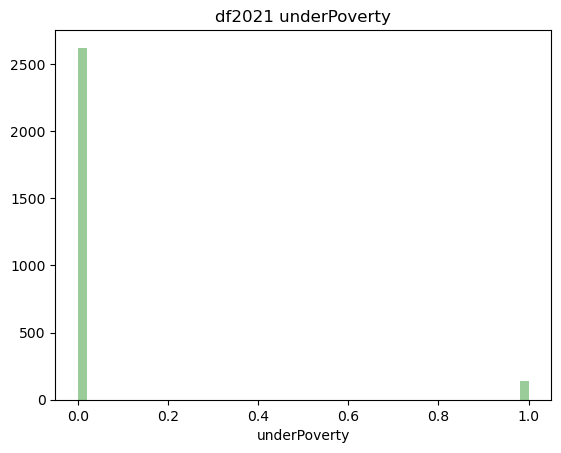

incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.102493
std         0.063519
min         0.000000
25%         0.058270
50%         0.089018
75%         0.130092
max         0.473985
Name: incomeBelowPovertyLevelProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------


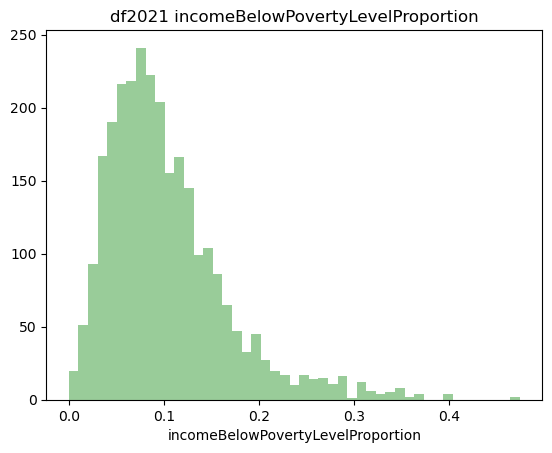

incomePerCapita
----------------------------------------------------------------------------
count      2762.000000
mean      37852.136495
std       17263.249927
min        5116.000000
25%       28145.750000
50%       33431.500000
75%       41647.750000
max      180412.000000
Name: incomePerCapita, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomePerCapita
----------------------------------------------------------------------------


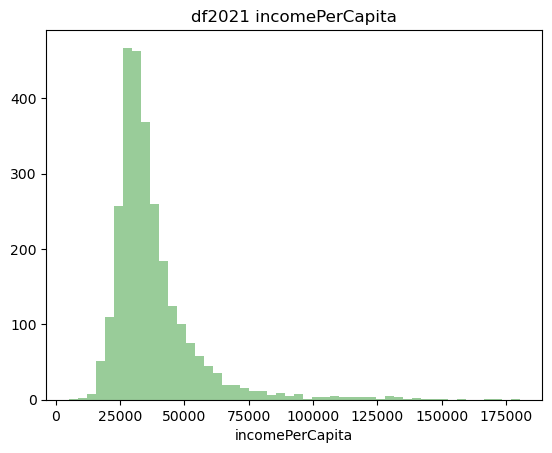

incomeGiniIndex
----------------------------------------------------------------------------
count    2762.000000
mean        0.421892
std         0.058448
min         0.156100
25%         0.384850
50%         0.417300
75%         0.455200
max         0.657200
Name: incomeGiniIndex, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeGiniIndex
----------------------------------------------------------------------------


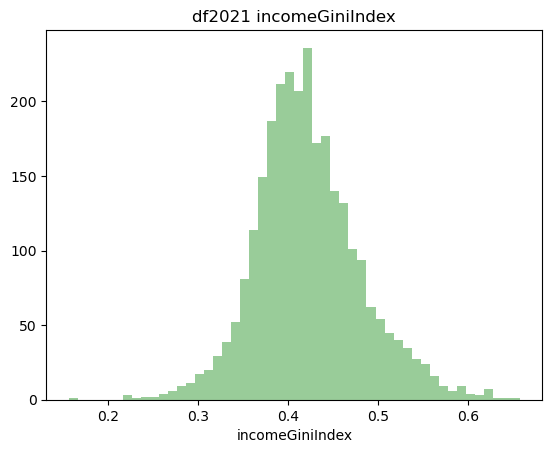

popDensity
----------------------------------------------------------------------------
count      2762.000000
mean       4194.044220
std       13579.232200
min           0.834195
25%          66.830888
50%         271.956550
75%        1854.641000
max      151475.800000
Name: popDensity, dtype: float64 
----------------------------------------------------------------------------
Distribution of popDensity
----------------------------------------------------------------------------


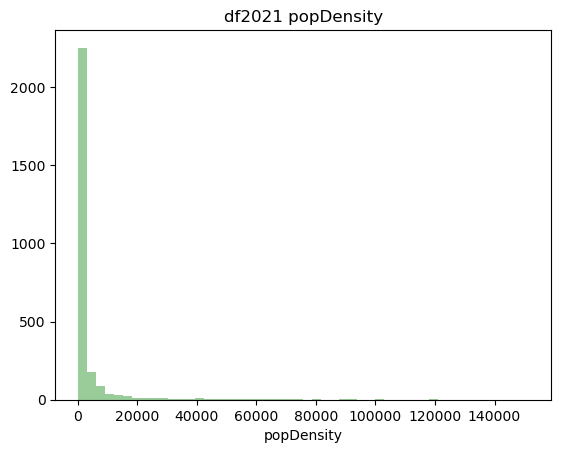

whiteMajority
----------------------------------------------------------------------------
count    2762.000000
mean        0.842032
std         0.196410
min         0.019053
25%         0.802563
50%         0.921079
75%         0.964396
max         1.000000
Name: whiteMajority, dtype: float64 
----------------------------------------------------------------------------
Distribution of whiteMajority
----------------------------------------------------------------------------


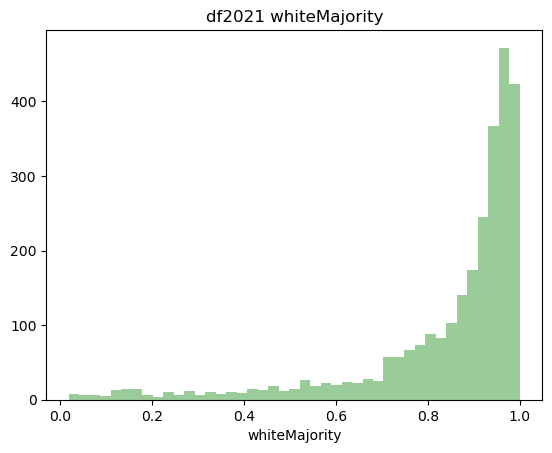

eduHsOrLessProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.096271
std         0.063522
min         0.000000
25%         0.053964
50%         0.082997
75%         0.119928
max         0.528090
Name: eduHsOrLessProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsOrLessProportion
----------------------------------------------------------------------------


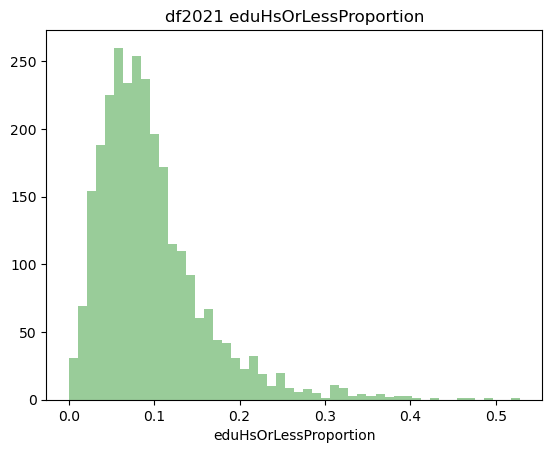

eduHsProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.610639
std         0.148644
min         0.030905
25%         0.536000
50%         0.644533
75%         0.715765
max         0.930636
Name: eduHsProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsProportion
----------------------------------------------------------------------------


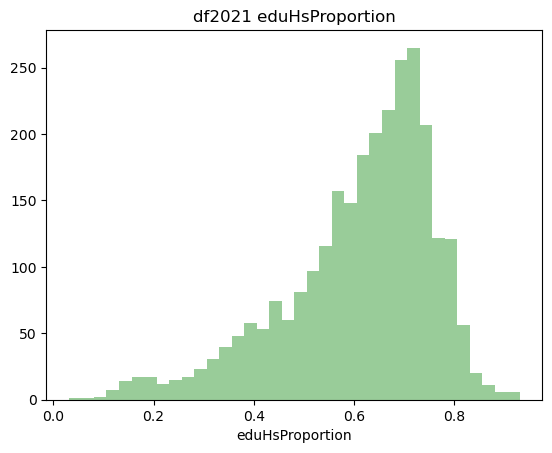

eduBachOrBetterProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.293090
std         0.166977
min         0.012195
25%         0.172751
50%         0.247534
75%         0.374775
max         0.965508
Name: eduBachOrBetterProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduBachOrBetterProportion
----------------------------------------------------------------------------


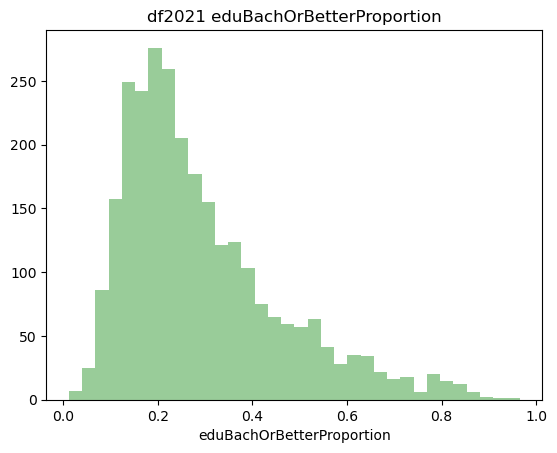

eduEnrollmentProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.218905
std         0.063484
min         0.000000
25%         0.183830
50%         0.215234
75%         0.248454
max         0.876300
Name: eduEnrollmentProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduEnrollmentProportion
----------------------------------------------------------------------------


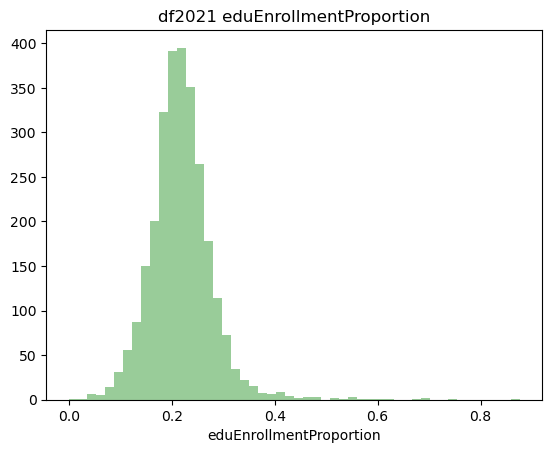

eduDropoutProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.055753
std         0.113325
min         0.000000
25%         0.000000
50%         0.011113
75%         0.058097
max         1.000000
Name: eduDropoutProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduDropoutProportion
----------------------------------------------------------------------------


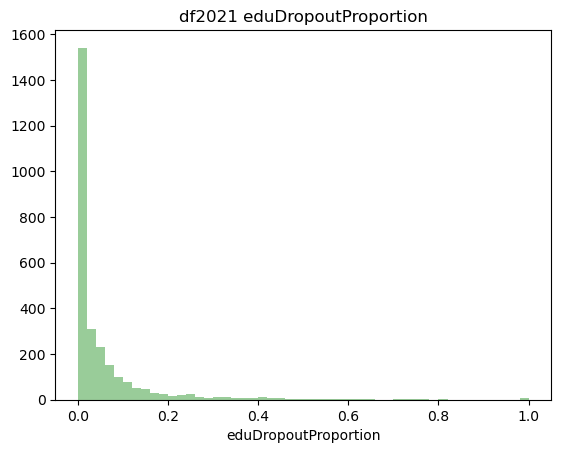

employedProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.945659
std         0.033943
min         0.672566
25%         0.931652
50%         0.951351
75%         0.967480
max         1.000000
Name: employedProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedProportion
----------------------------------------------------------------------------


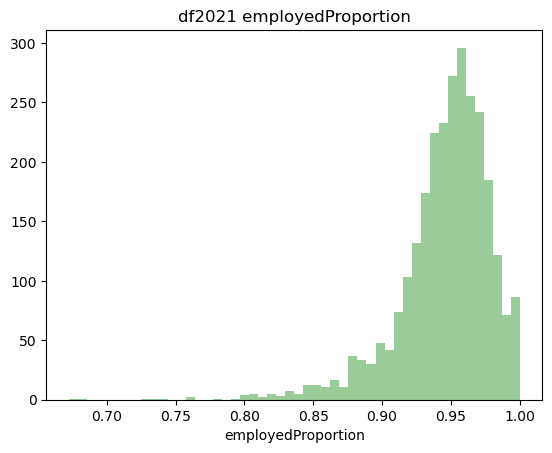

employedPvtSecProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.643166
std         0.094417
min         0.177778
25%         0.591457
50%         0.651538
75%         0.703504
max         0.965035
Name: employedPvtSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtSecProportion
----------------------------------------------------------------------------


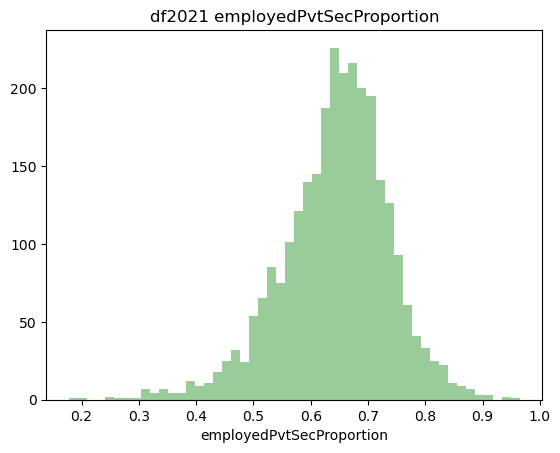

employedPubSecProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.149205
std         0.069294
min         0.000000
25%         0.099606
50%         0.140871
75%         0.187346
max         0.655556
Name: employedPubSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPubSecProportion
----------------------------------------------------------------------------


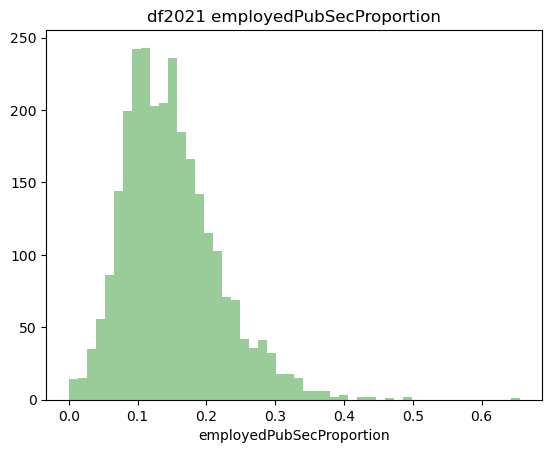

employedSelfEmpProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.096581
std         0.051785
min         0.000000
25%         0.062881
50%         0.086922
75%         0.118828
max         0.444238
Name: employedSelfEmpProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedSelfEmpProportion
----------------------------------------------------------------------------


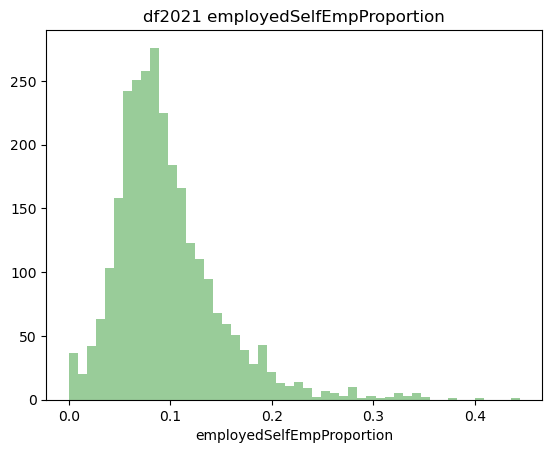

employedPvtNonProProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.108756
std         0.050685
min         0.000000
25%         0.077732
50%         0.102559
75%         0.132468
max         0.534653
Name: employedPvtNonProProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtNonProProportion
----------------------------------------------------------------------------


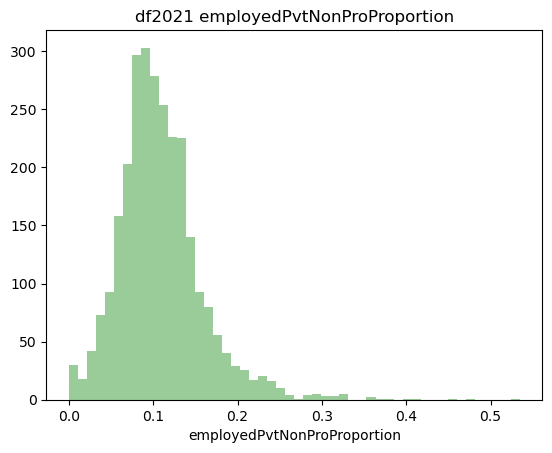

employedUnpaidFamProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.002291
std         0.006065
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002183
max         0.115092
Name: employedUnpaidFamProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedUnpaidFamProportion
----------------------------------------------------------------------------


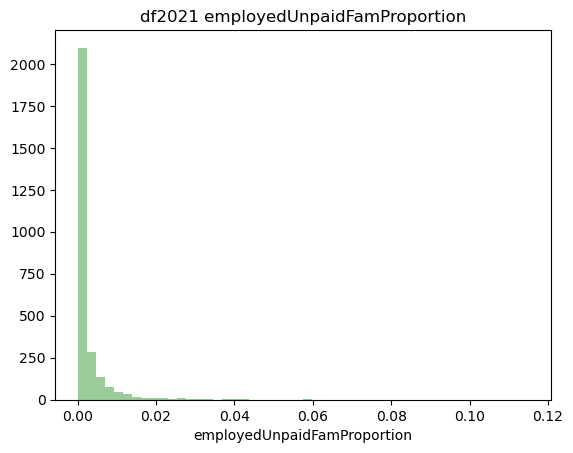

insuredProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.944078
std         0.054047
min         0.393746
25%         0.933320
50%         0.956894
75%         0.973802
max         1.000000
Name: insuredProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of insuredProportion
----------------------------------------------------------------------------


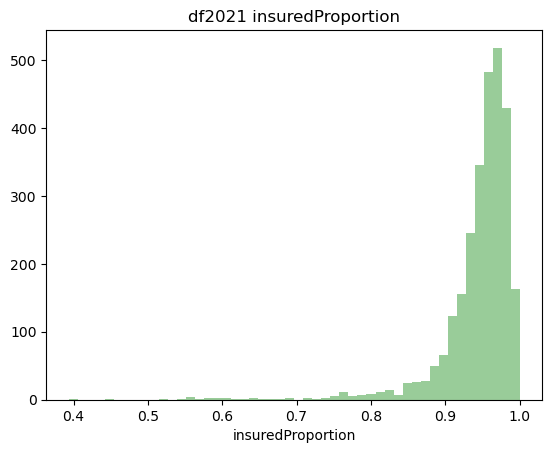

housingRentMoreThan30pcProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.391692
std         0.158037
min         0.000000
25%         0.289294
50%         0.400691
75%         0.495768
max         1.000000
Name: housingRentMoreThan30pcProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingRentMoreThan30pcProportion
----------------------------------------------------------------------------


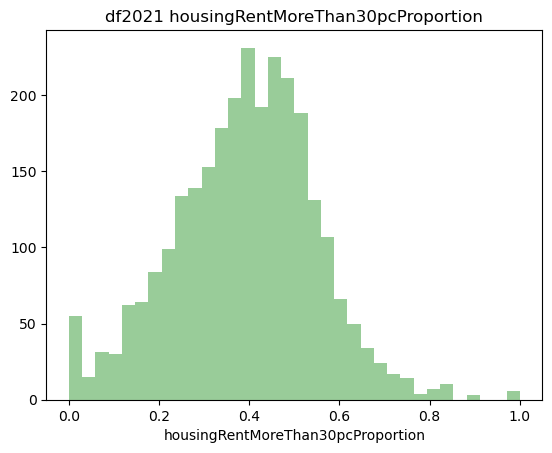

housingMedianValue
----------------------------------------------------------------------------
count    2.762000e+03
mean     2.482243e+05
std      2.244529e+05
min      9.999000e+03
25%      1.219250e+05
50%      1.708000e+05
75%      2.732750e+05
max      2.000001e+06
Name: housingMedianValue, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianValue
----------------------------------------------------------------------------


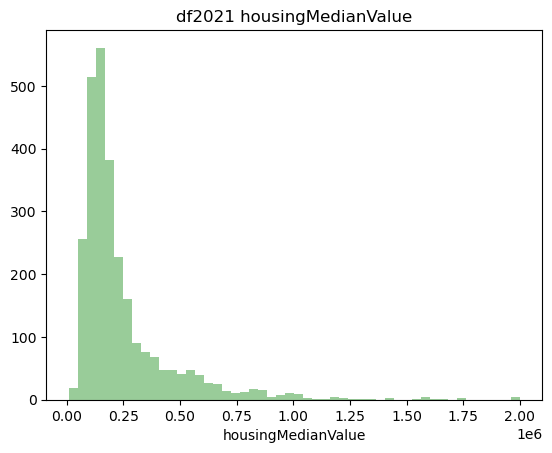

housingMedianGrossRent
----------------------------------------------------------------------------
count    2762.000000
mean     1073.119841
std       472.617585
min       379.000000
25%       754.000000
50%       921.000000
75%      1232.750000
max      3501.000000
Name: housingMedianGrossRent, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianGrossRent
----------------------------------------------------------------------------


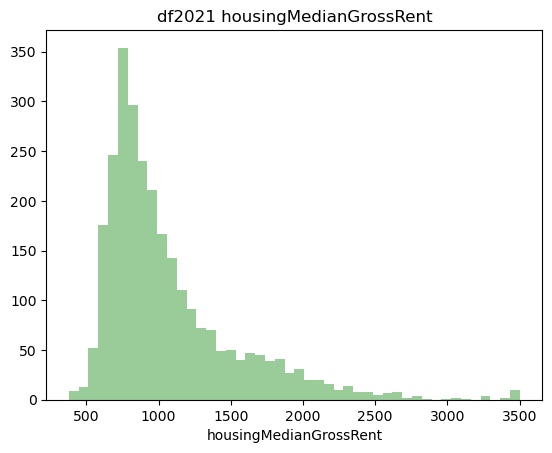

CPU times: total: 23 s
Wall time: 48.8 s


In [10]:
%%time
for key, df in dfs.items(): 
    print(f"Description of columns for {key}")
    for column in columnNames:
        print(column)
        print("----------------------------------------------------------------------------")
        print(df[column].describe(),end=' ')


        plt.figure()
        plt.title(key+" "+column)
        print("\n----------------------------------------------------------------------------")
        print("Distribution of " + column)
        print("----------------------------------------------------------------------------")
        sns.distplot(df[column], kde=False, color='g');
        plt.show()


### Outlier Analysis

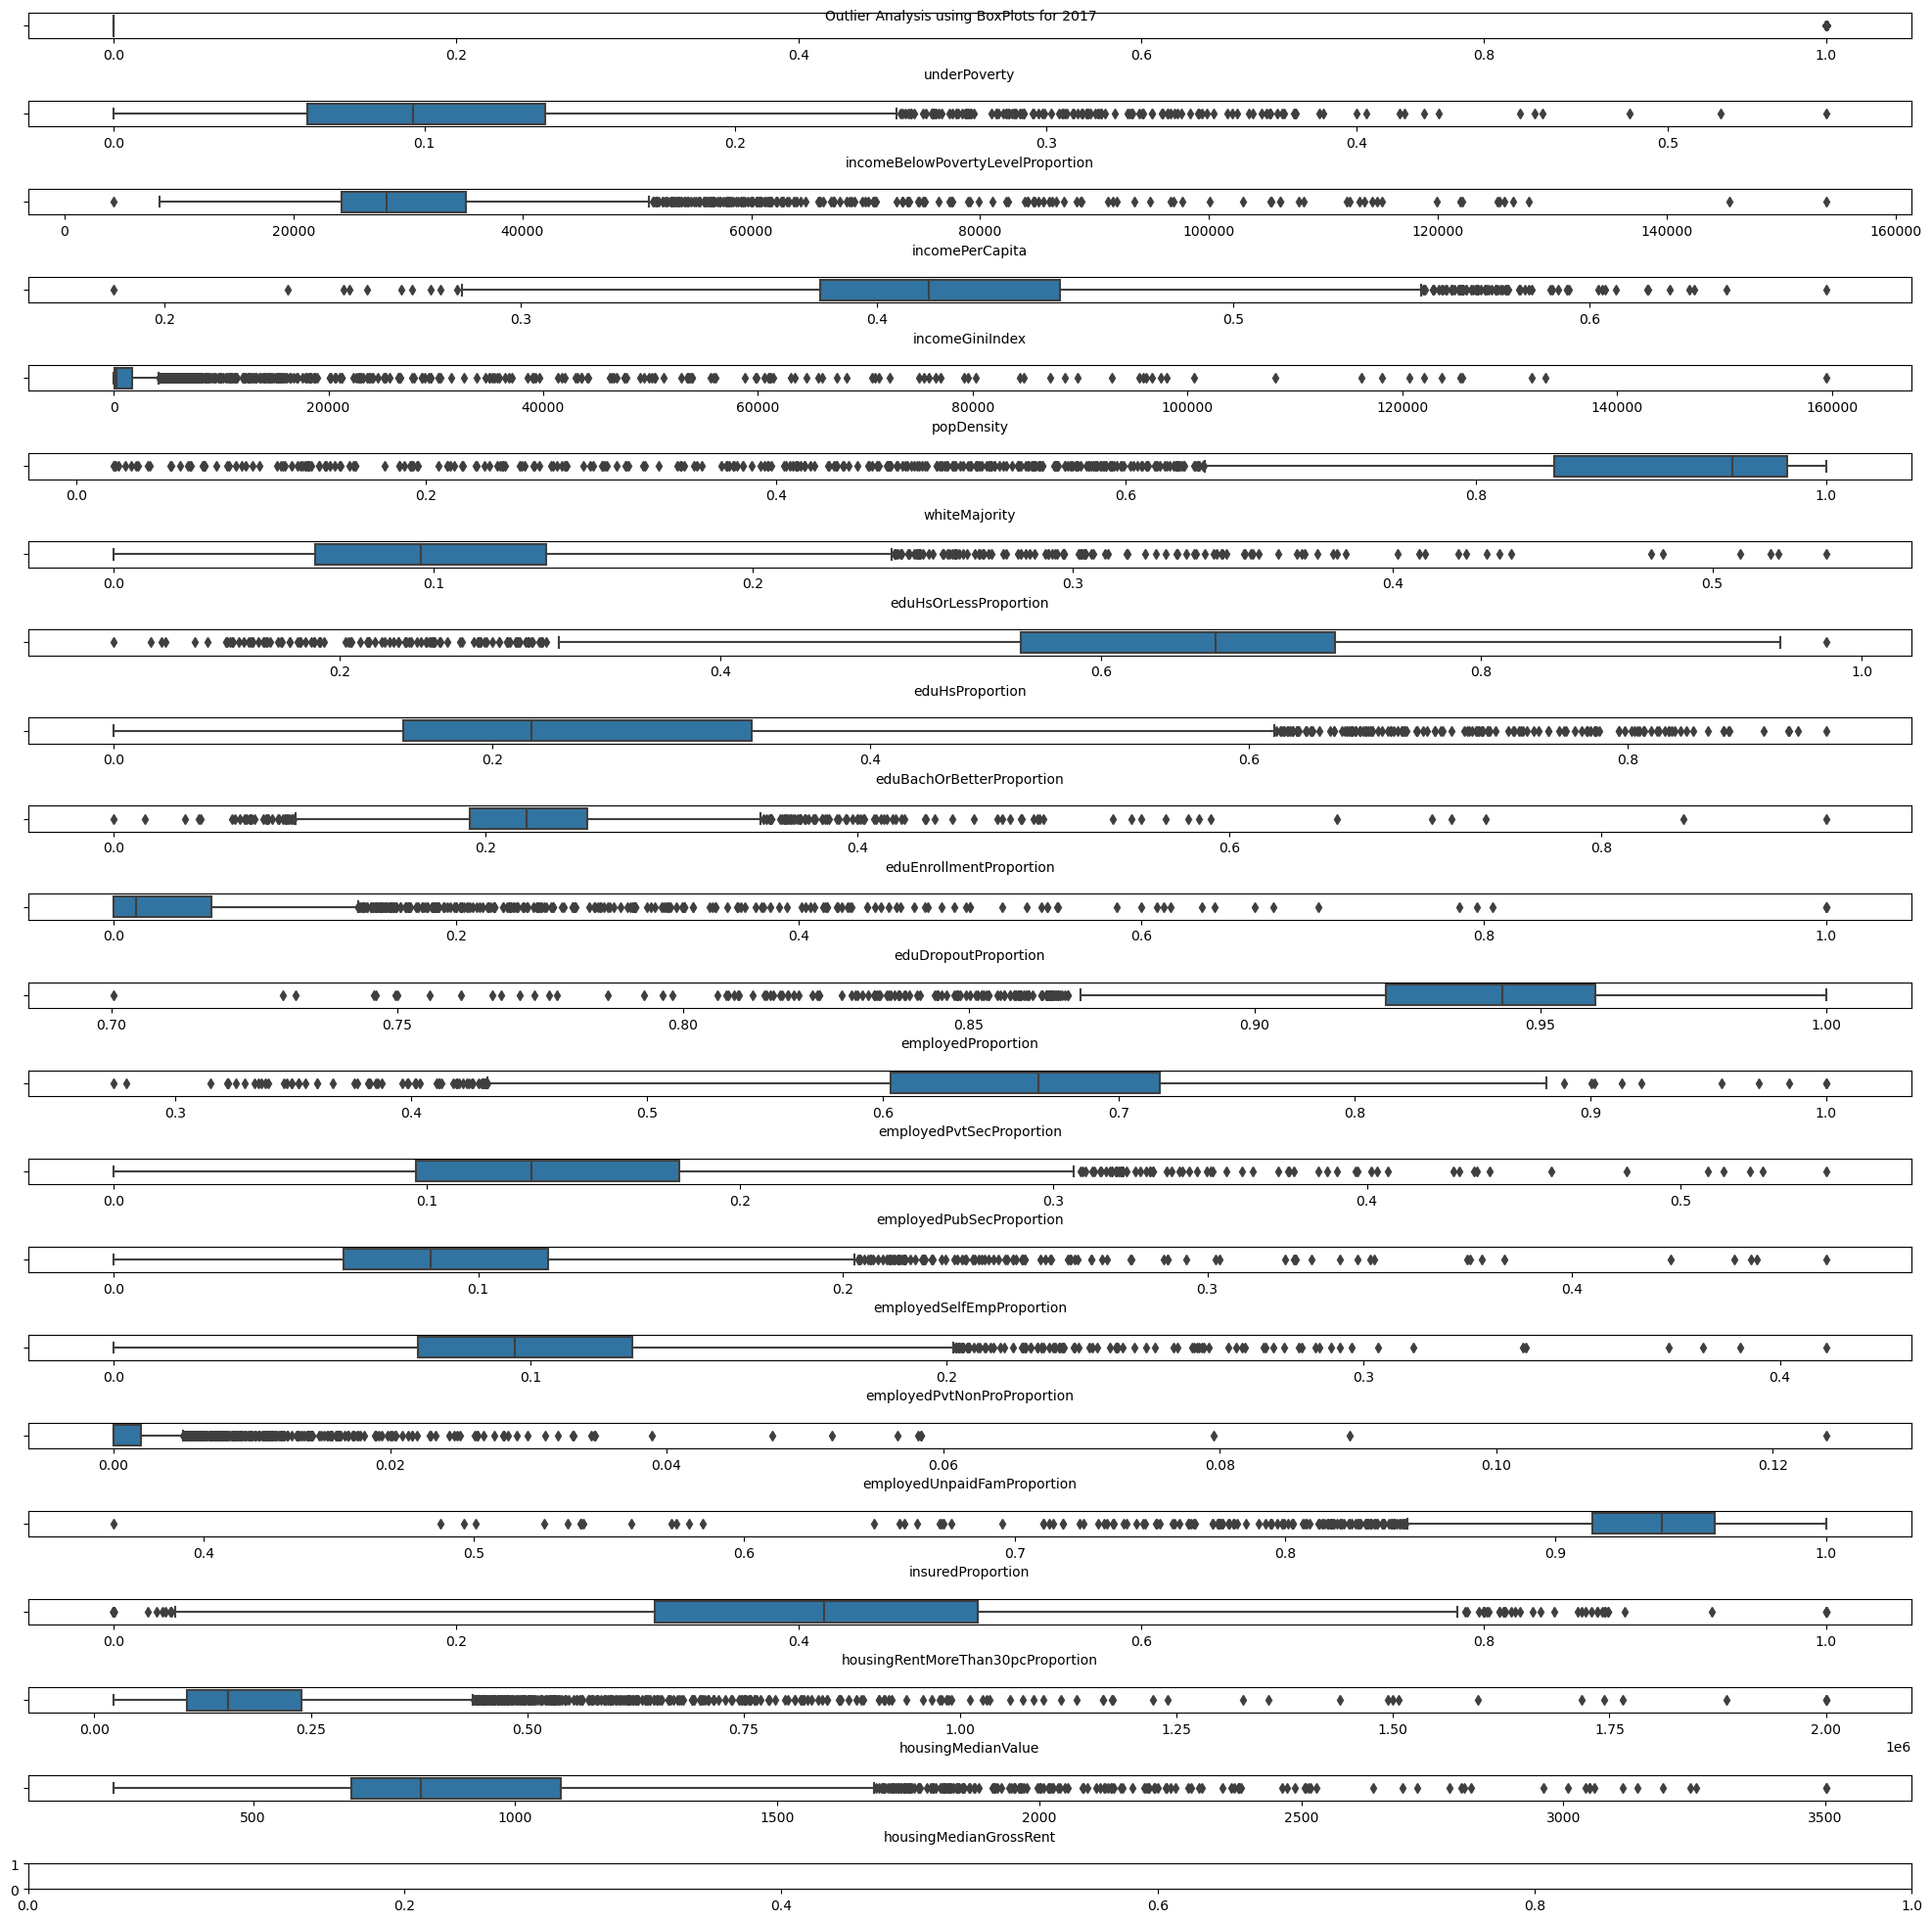

In [11]:
fig, ax = plt.subplots(22, figsize=(20, 20))
ax = ax.flatten()
for i, c in enumerate(dfs['df2017'].columns):
    sns.boxplot(x=dfs['df2017'].iloc[:, i], ax=ax[i])
    
plt.suptitle('Outlier Analysis using BoxPlots for 2017', fontsize=10)
fig.tight_layout()

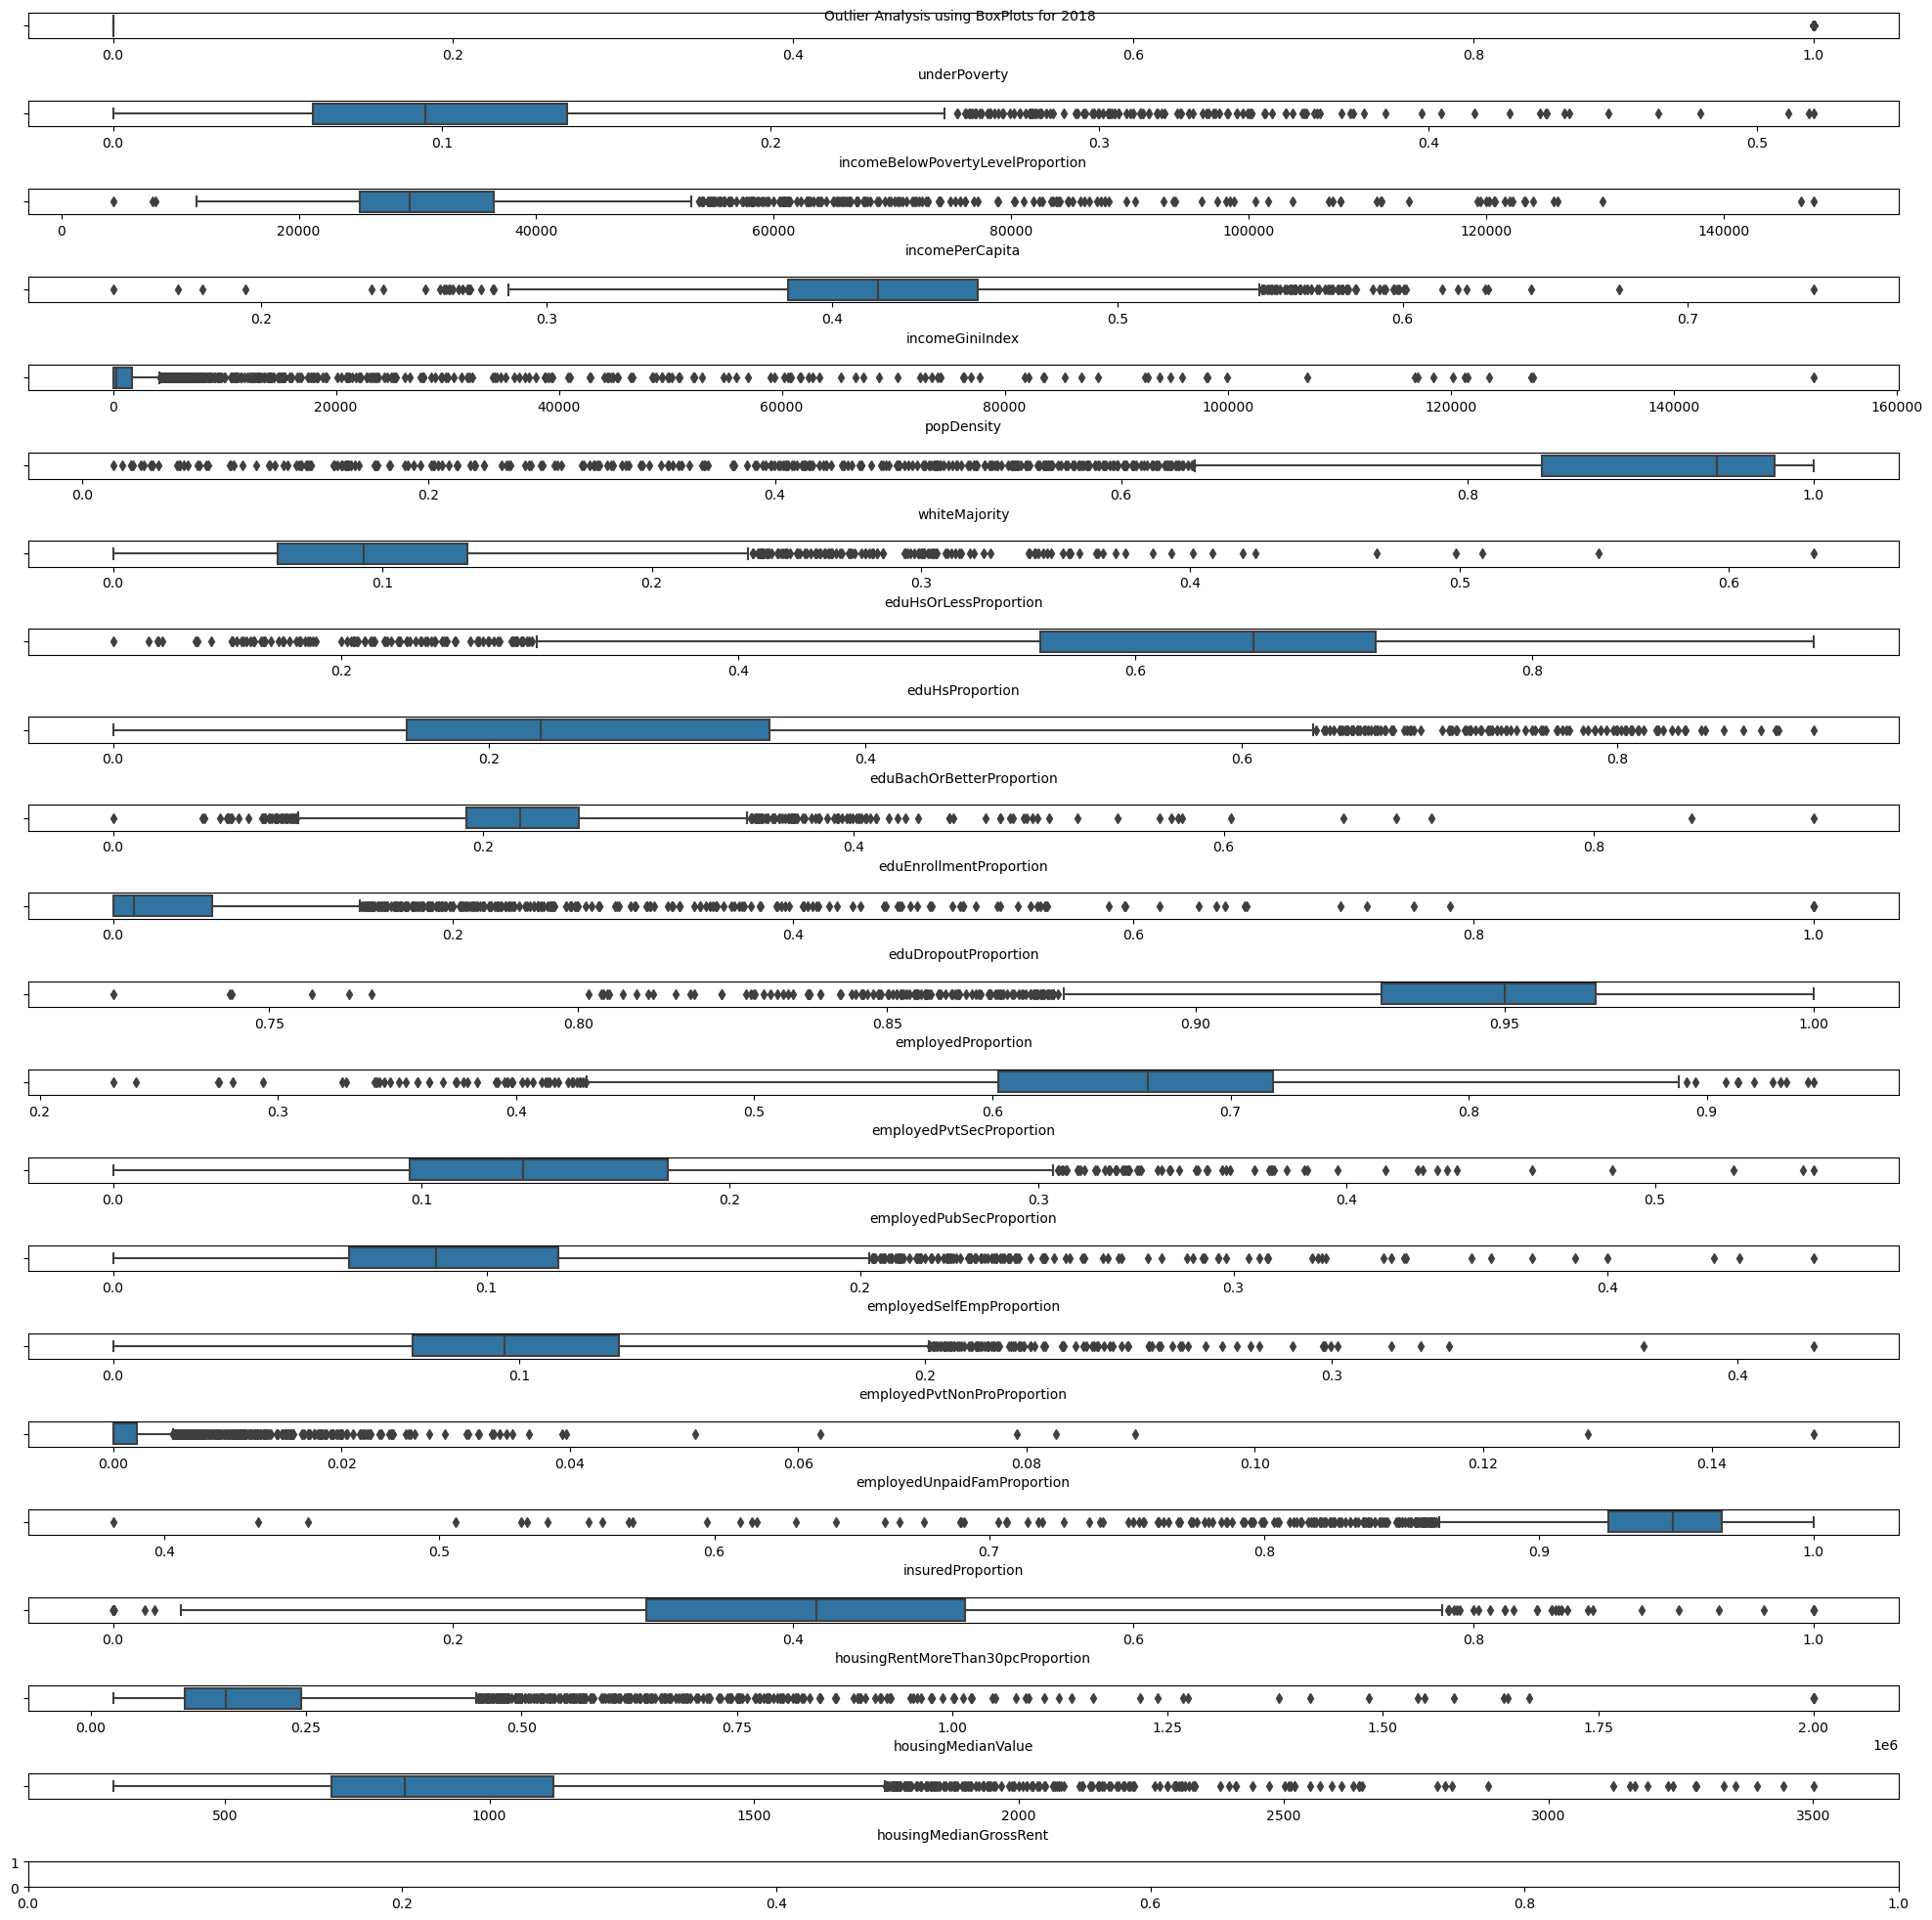

In [12]:
fig, ax = plt.subplots(22, figsize=(20, 20))
ax = ax.flatten()

for i, c in enumerate(dfs['df2018'].columns):
    sns.boxplot(x=dfs['df2018'].iloc[:, i], ax=ax[i])
    
plt.suptitle('Outlier Analysis using BoxPlots for 2018', fontsize=10)
fig.tight_layout()

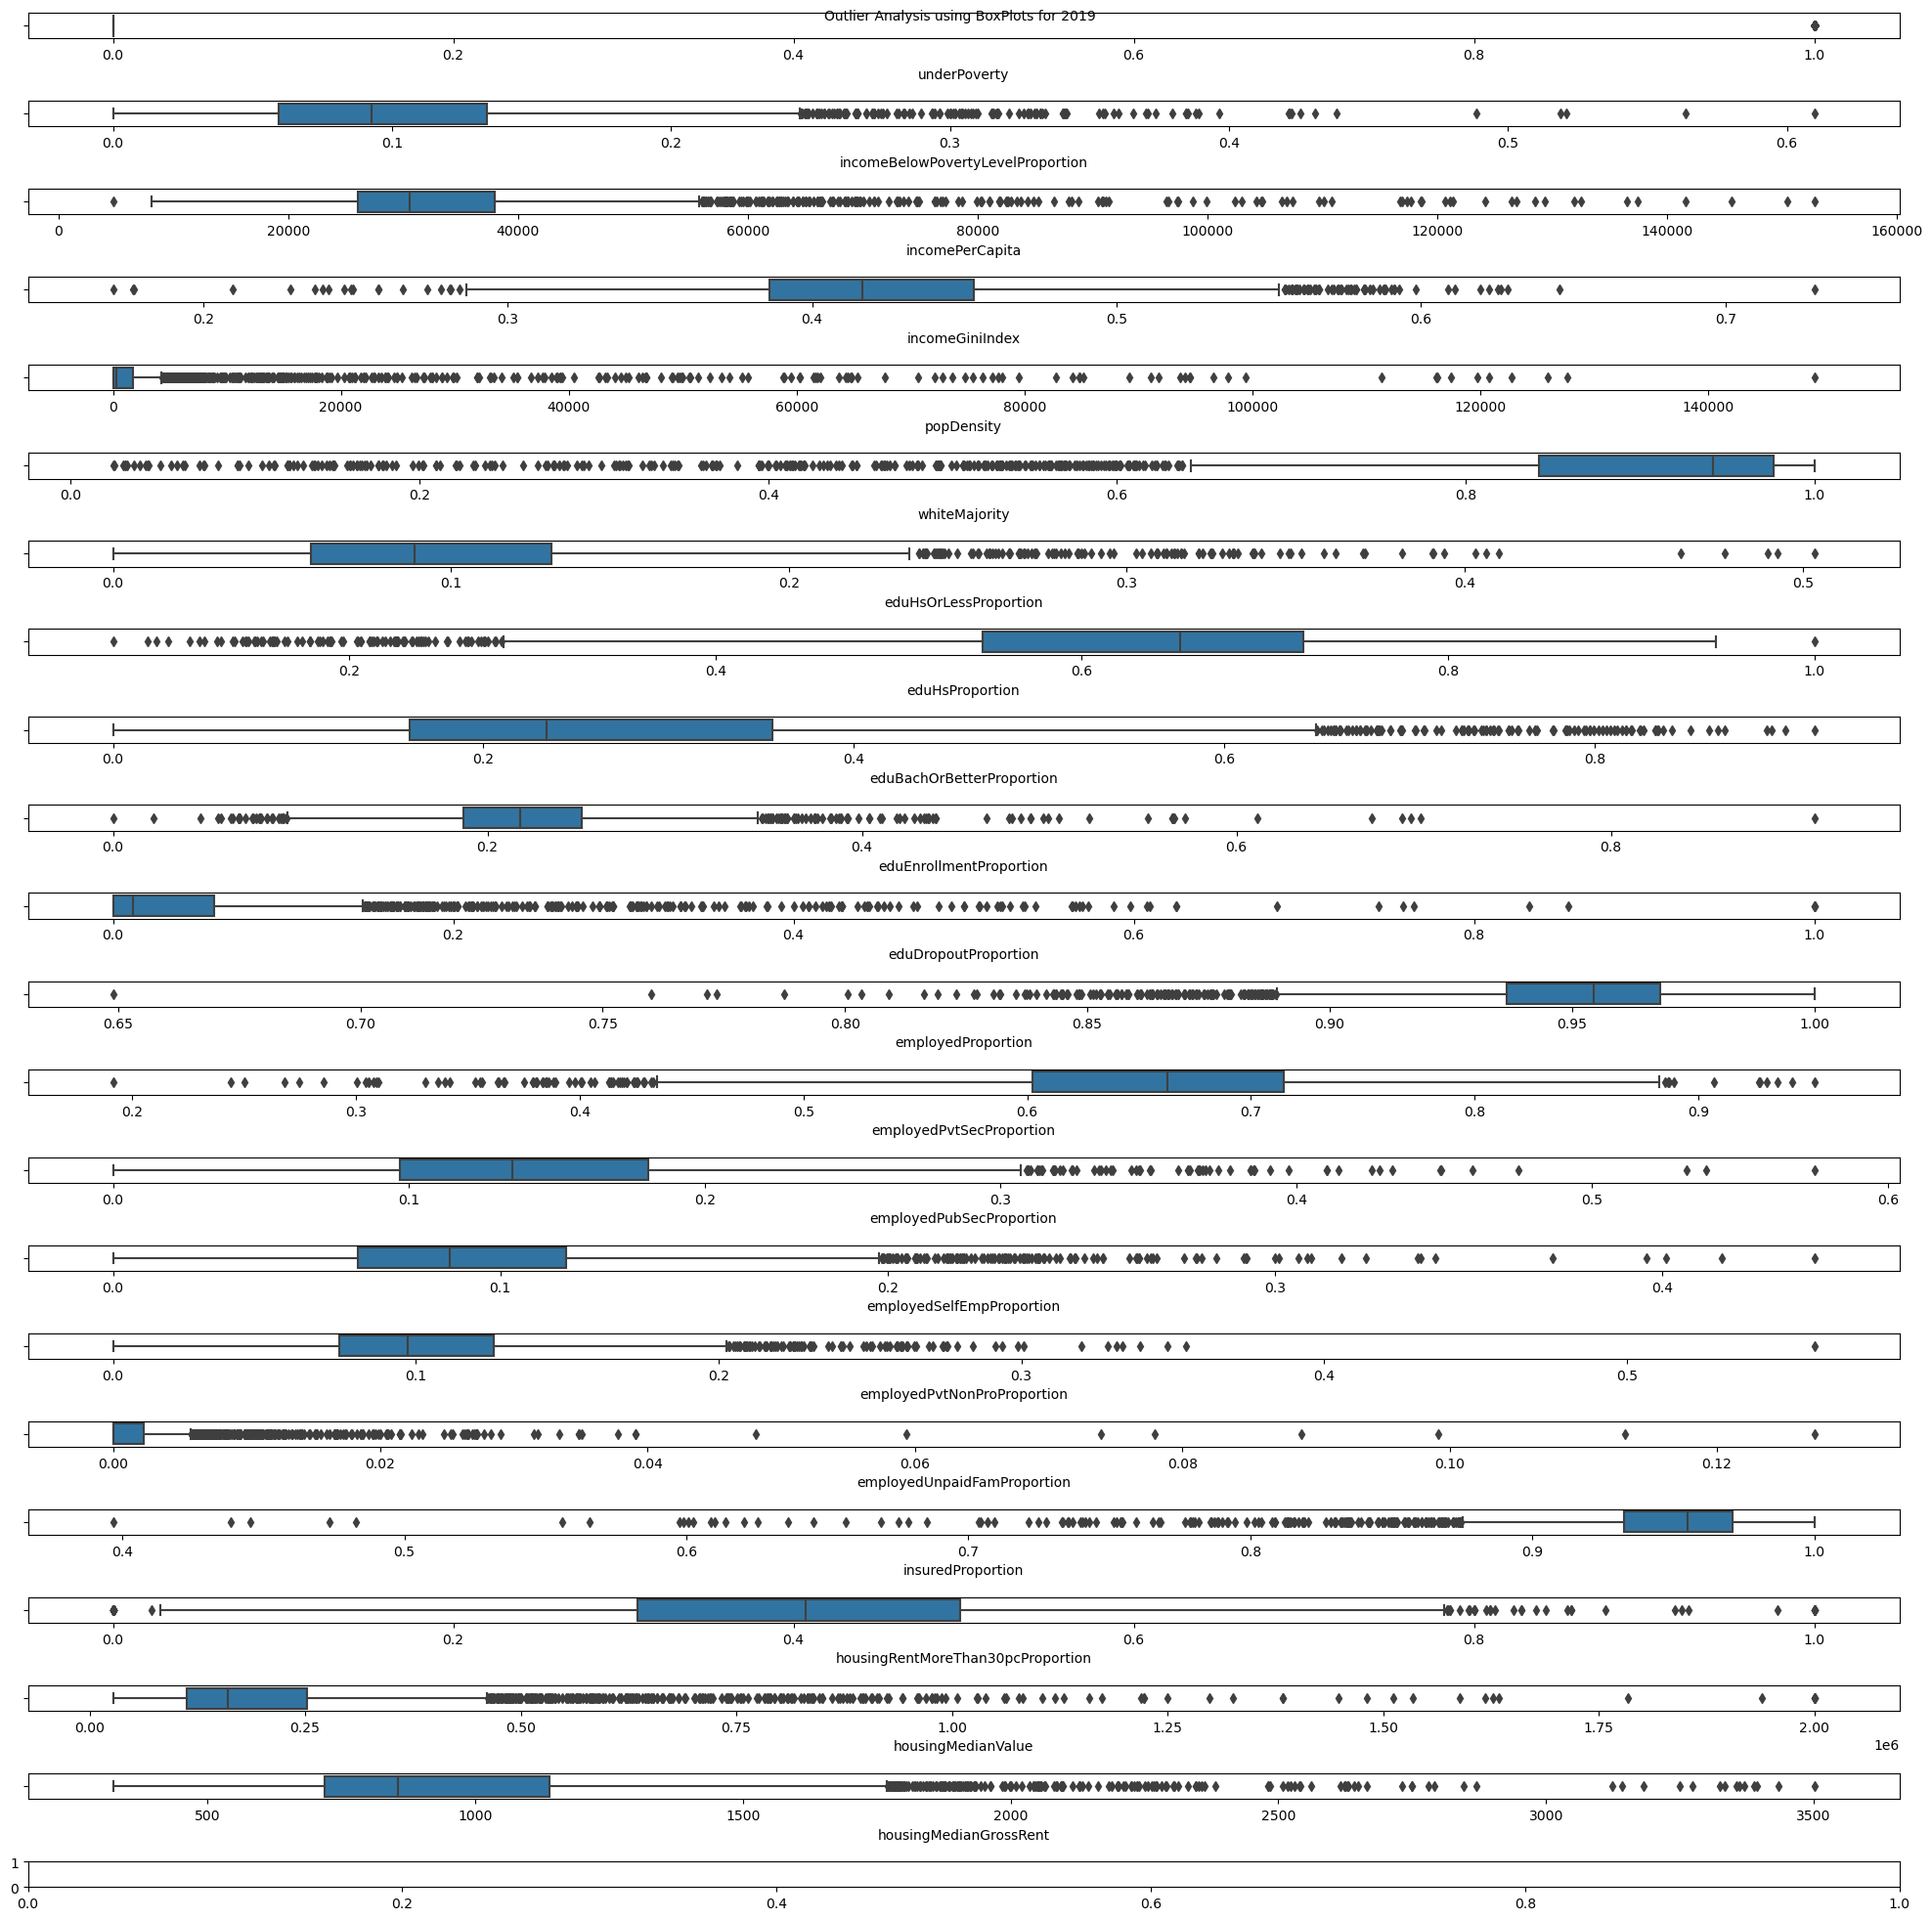

In [13]:
fig, ax = plt.subplots(22, figsize=(20, 20))
ax = ax.flatten()

for i, c in enumerate(dfs['df2019'].columns):
    sns.boxplot(x=dfs['df2019'].iloc[:, i], ax=ax[i])
    #ax[i].set_title(c)
    
plt.suptitle('Outlier Analysis using BoxPlots for 2019', fontsize=10)
fig.tight_layout()

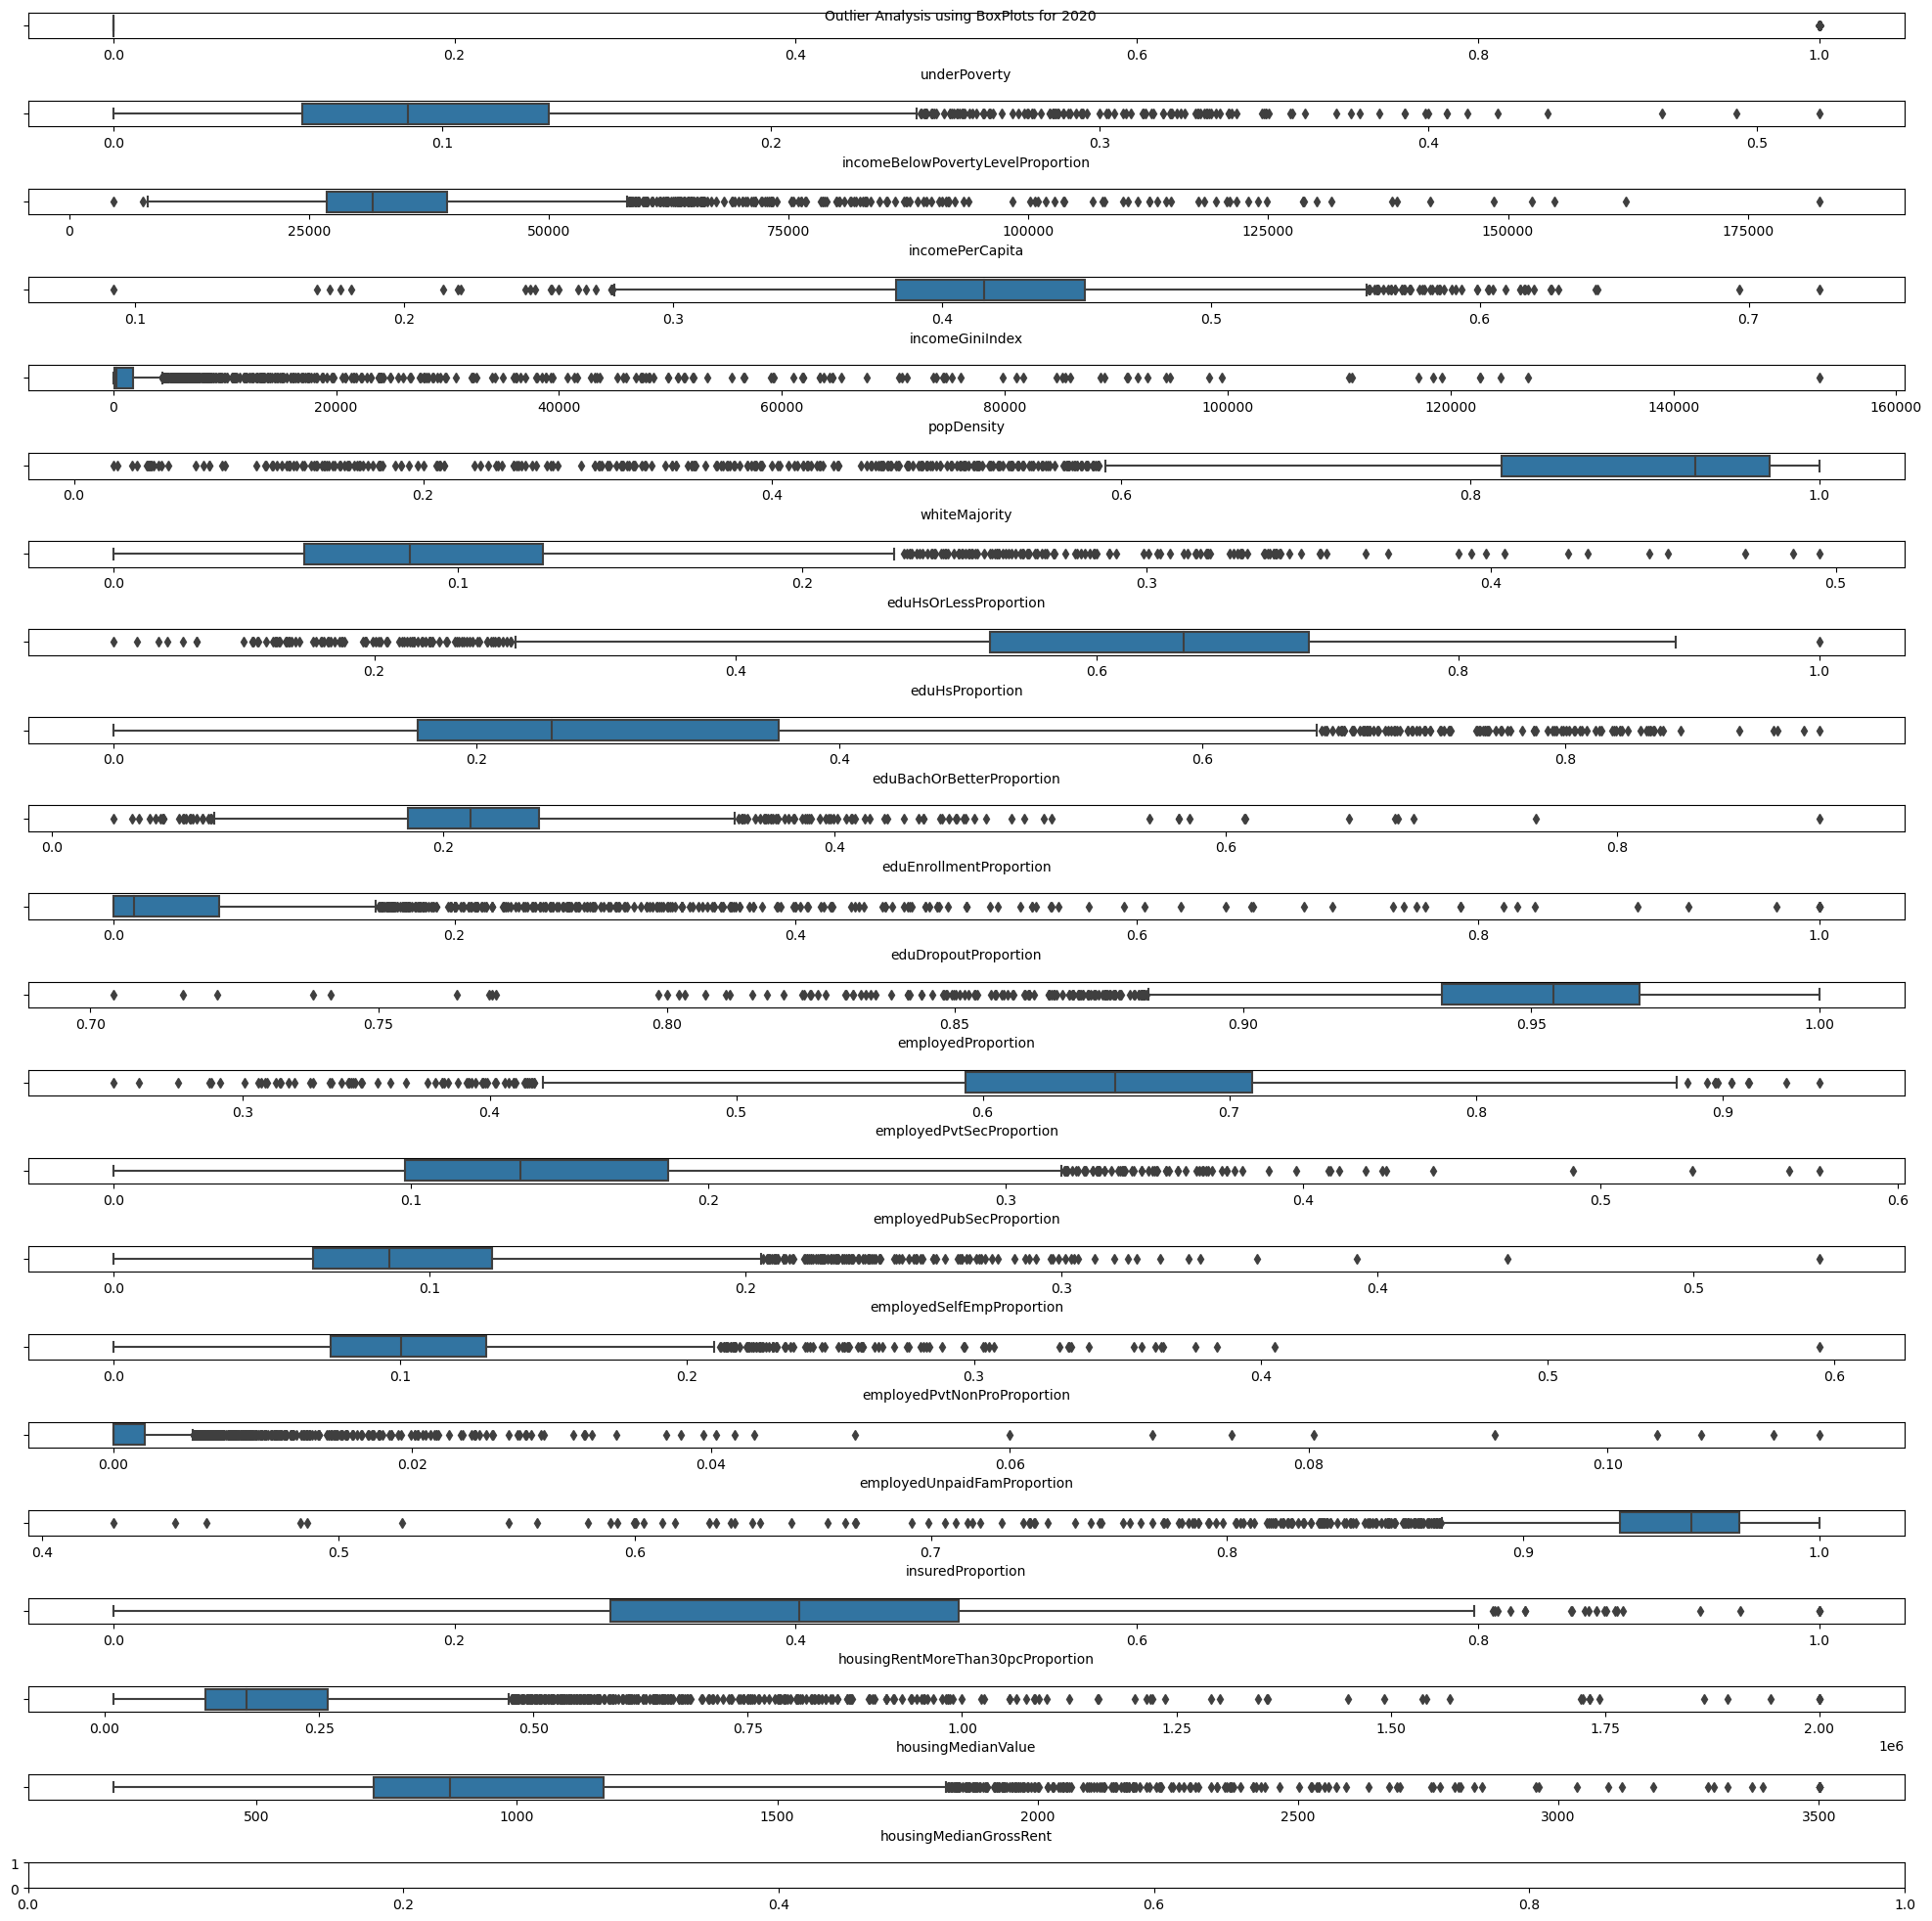

In [14]:
fig, ax = plt.subplots(22, figsize=(20, 20))
ax = ax.flatten()

for i, c in enumerate(dfs['df2020'].columns):
    sns.boxplot(x=dfs['df2020'].iloc[:, i], ax=ax[i])
    
plt.suptitle('Outlier Analysis using BoxPlots for 2020', fontsize=10)
fig.tight_layout()

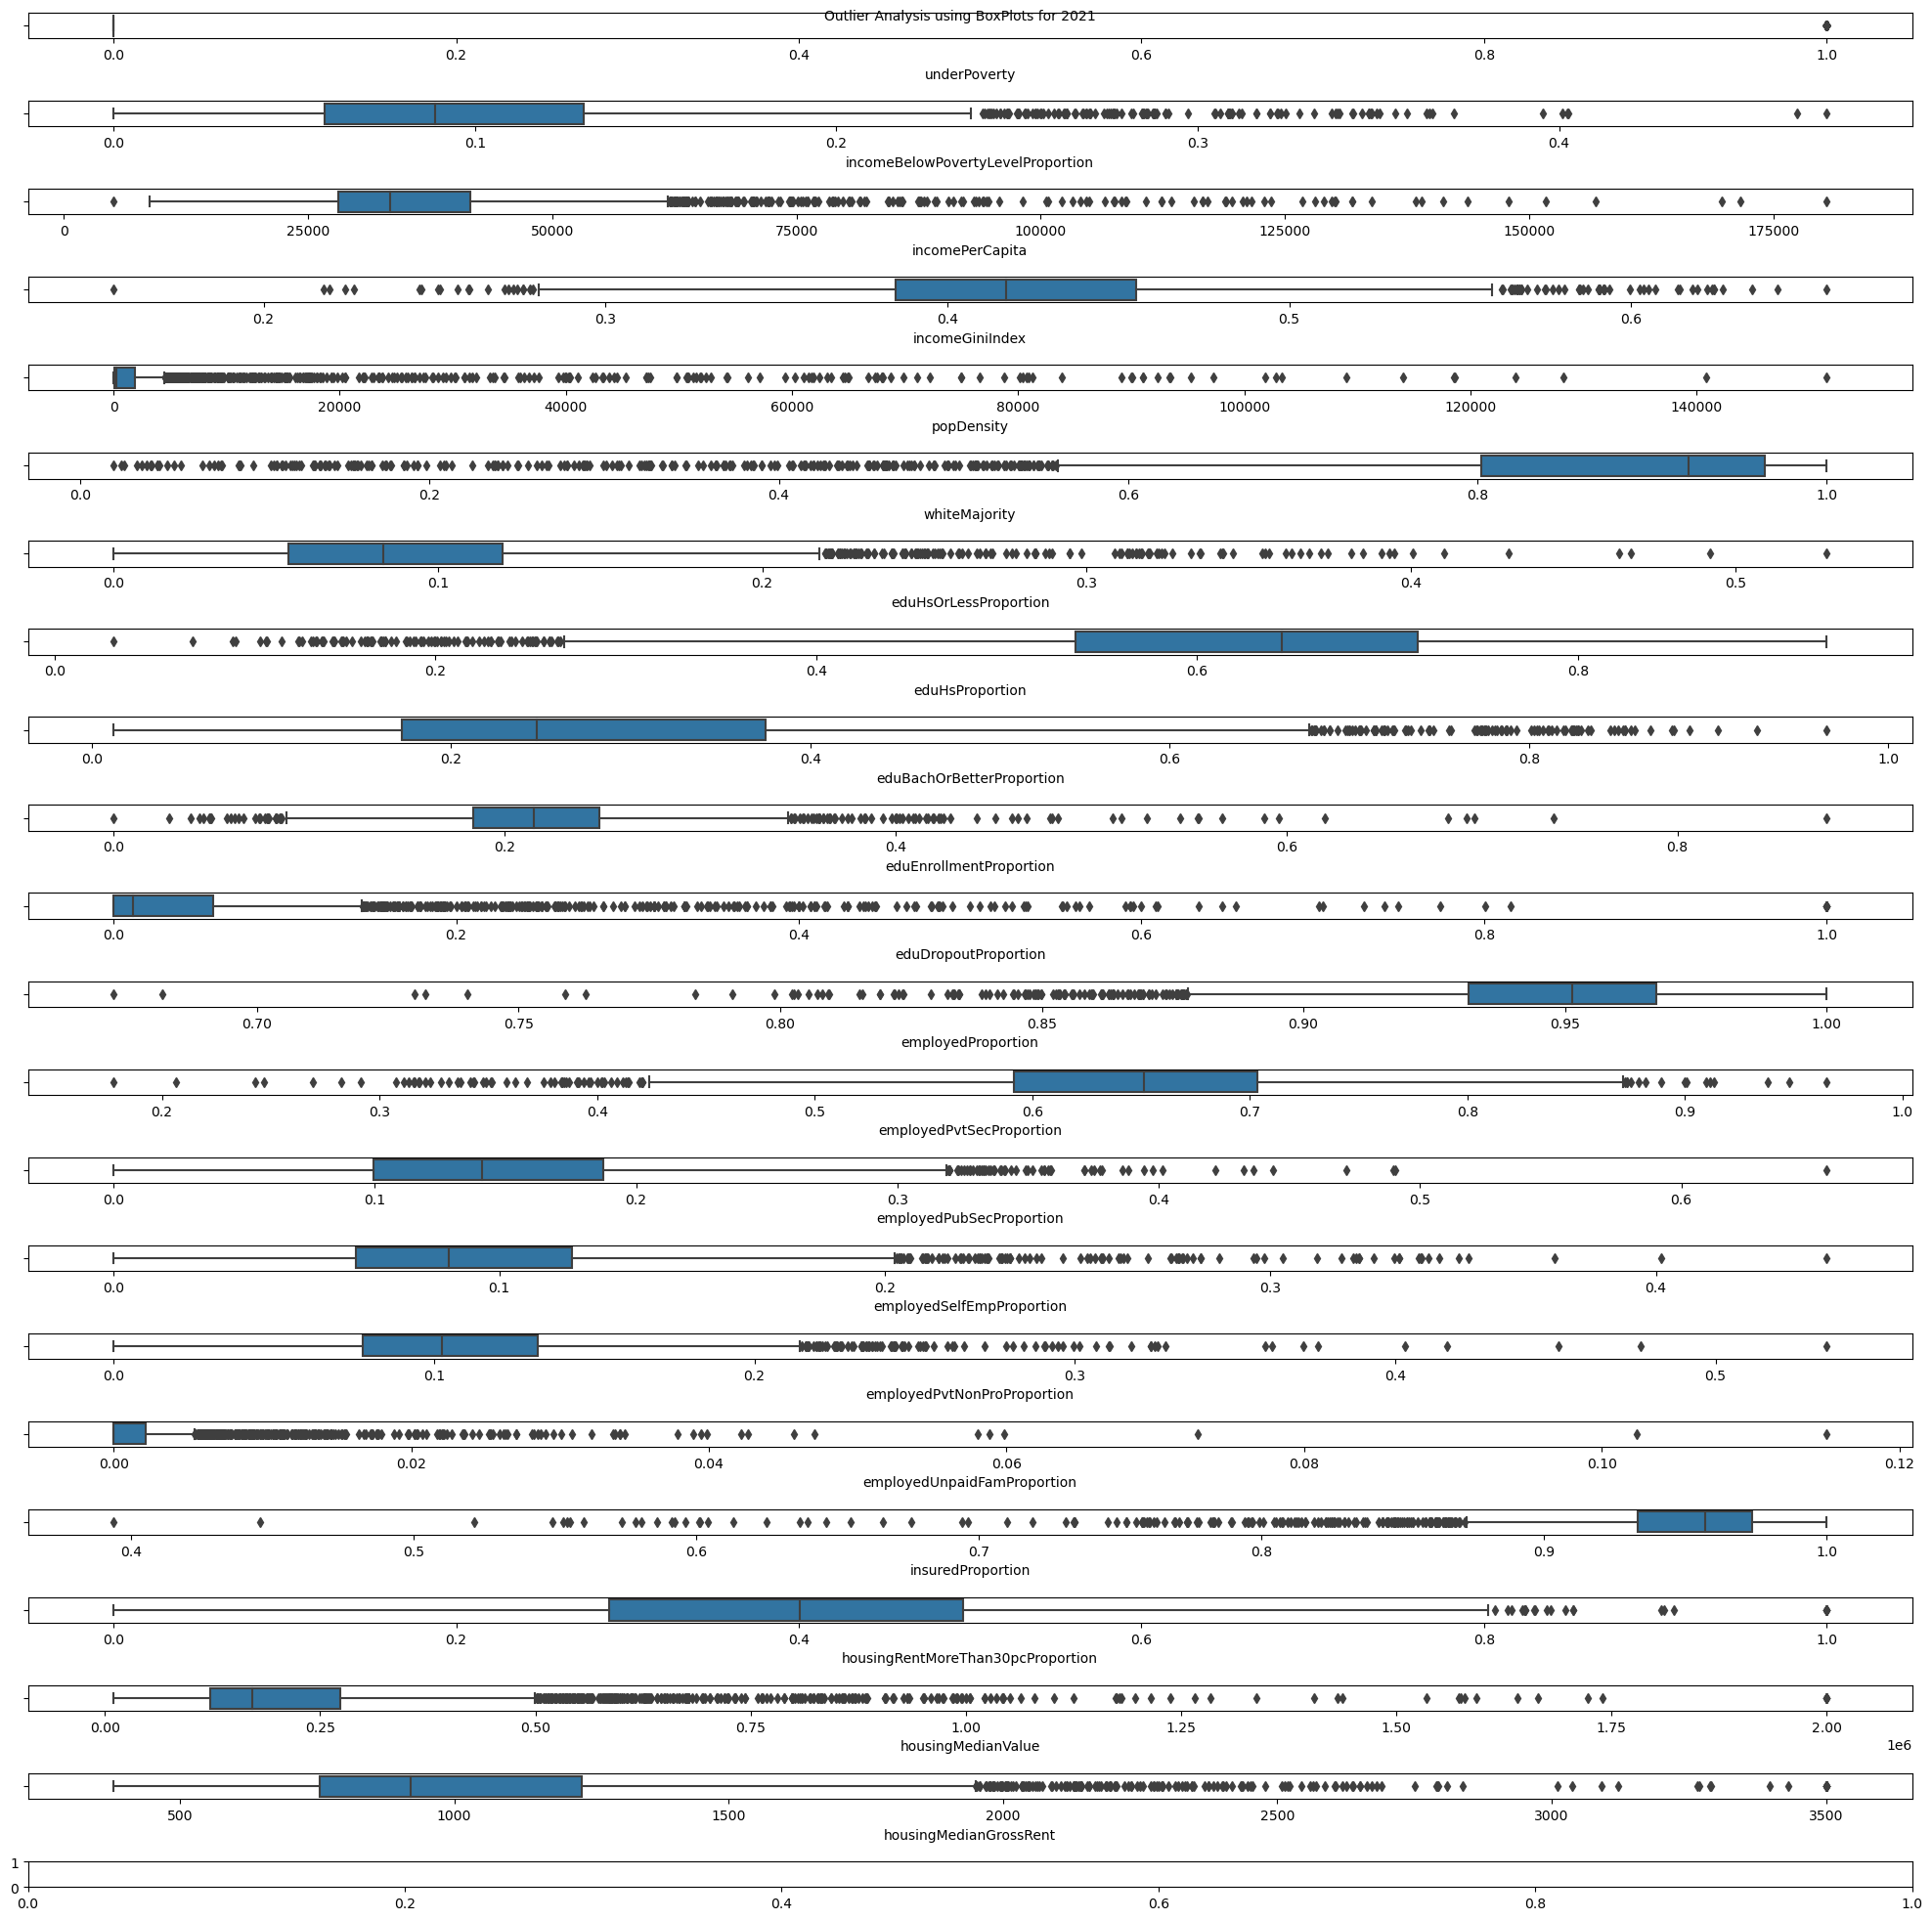

In [15]:
fig, ax = plt.subplots(22, figsize=(20, 20))
ax = ax.flatten()

for i, c in enumerate(dfs['df2021'].columns):
    sns.boxplot(x=dfs['df2021'].iloc[:, i], ax=ax[i])
    #ax[i].set_title(c)
    
plt.suptitle('Outlier Analysis using BoxPlots for 2021', fontsize=10)
fig.tight_layout()

### Interactive plot

In [16]:
# Create dropdown widgets for x and y axis variables
x_var_dropdown = widgets.Dropdown(options=list(dfs['df2017'].columns[2:]), description='X Axis')
y_var_dropdown = widgets.Dropdown(options=list(dfs['df2017'].columns[2:]), description='Y Axis')

# Define function to create the scatter plot
def scatterplot(x_var, y_var):
    print('Scatterplot for 2017')
    fig = px.scatter(dfs['df2017'], x=x_var, y=y_var, color='underPoverty', hover_data=[dfs['df2017'].index])
    fig.show()
    
# Create interactive plot using the scatterplot function and the dropdown widgets
interactive_plot = interact(scatterplot, x_var=x_var_dropdown, y_var=y_var_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='X Axis', options=('incomePerCapita', 'incomeGiniIndex', 'popDensit…

<function __main__.scatterplot(x_var, y_var)>

In [17]:
# Create dropdown widgets for x and y axis variables
x_var_dropdown = widgets.Dropdown(options=list(dfs['df2018'].columns[2:]), description='X Axis')
y_var_dropdown = widgets.Dropdown(options=list(dfs['df2018'].columns[2:]), description='Y Axis')

# Define function to create the scatter plot
def scatterplot(x_var, y_var):
    print('Scatterplot for 2018')
    fig = px.scatter(dfs['df2018'], x=x_var, y=y_var, color='underPoverty', hover_data=[dfs['df2018'].index])
    fig.show()
    
# Create interactive plot using the scatterplot function and the dropdown widgets
interactive_plot = interact(scatterplot, x_var=x_var_dropdown, y_var=y_var_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='X Axis', options=('incomePerCapita', 'incomeGiniIndex', 'popDensit…

<function __main__.scatterplot(x_var, y_var)>

In [18]:
# Create dropdown widgets for x and y axis variables
x_var_dropdown = widgets.Dropdown(options=list(dfs['df2019'].columns[2:]), description='X Axis')
y_var_dropdown = widgets.Dropdown(options=list(dfs['df2019'].columns[2:]), description='Y Axis')

# Define function to create the scatter plot
def scatterplot(x_var, y_var):
    print('Scatterplot for 2019')
    fig = px.scatter(dfs['df2019'], x=x_var, y=y_var, color='underPoverty', hover_data=[dfs['df2019'].index])
    fig.show()
    
# Create interactive plot using the scatterplot function and the dropdown widgets
interactive_plot = interact(scatterplot, x_var=x_var_dropdown, y_var=y_var_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='X Axis', options=('incomePerCapita', 'incomeGiniIndex', 'popDensit…

<function __main__.scatterplot(x_var, y_var)>

In [19]:
# Create dropdown widgets for x and y axis variables
x_var_dropdown = widgets.Dropdown(options=list(dfs['df2020'].columns[2:]), description='X Axis')
y_var_dropdown = widgets.Dropdown(options=list(dfs['df2020'].columns[2:]), description='Y Axis')

# Define function to create the scatter plot
def scatterplot(x_var, y_var):
    print('Scatterplot for 2020')
    fig = px.scatter(dfs['df2020'], x=x_var, y=y_var, color='underPoverty', hover_data=[dfs['df2020'].index])
    fig.show()
    
# Create interactive plot using the scatterplot function and the dropdown widgets
interactive_plot = interact(scatterplot, x_var=x_var_dropdown, y_var=y_var_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='X Axis', options=('incomePerCapita', 'incomeGiniIndex', 'popDensit…

<function __main__.scatterplot(x_var, y_var)>

In [20]:
# Create dropdown widgets for x and y axis variables
x_var_dropdown = widgets.Dropdown(options=list(dfs['df2021'].columns[2:]), description='X Axis')
y_var_dropdown = widgets.Dropdown(options=list(dfs['df2021'].columns[2:]), description='Y Axis')

# Define function to create the scatter plot
def scatterplot(x_var, y_var):
    print('Scatterplot for 2021')
    fig = px.scatter(dfs['df2021'], x=x_var, y=y_var, color='underPoverty', hover_data=[dfs['df2021'].index])
    fig.show()
    
# Create interactive plot using the scatterplot function and the dropdown widgets
interactive_plot = interact(scatterplot, x_var=x_var_dropdown, y_var=y_var_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='X Axis', options=('incomePerCapita', 'incomeGiniIndex', 'popDensit…

<function __main__.scatterplot(x_var, y_var)>

# Clustering

### KMeans

Beginning df2021 clustering
Scaling df2017 columns
KMeans clustering on df2017
Beginning df2021 clustering
Scaling df2018 columns
KMeans clustering on df2018
Beginning df2021 clustering
Scaling df2019 columns
KMeans clustering on df2019
Beginning df2021 clustering
Scaling df2020 columns
KMeans clustering on df2020
Beginning df2021 clustering
Scaling df2021 columns
KMeans clustering on df2021
CPU times: total: 2min 47s
Wall time: 44.4 s


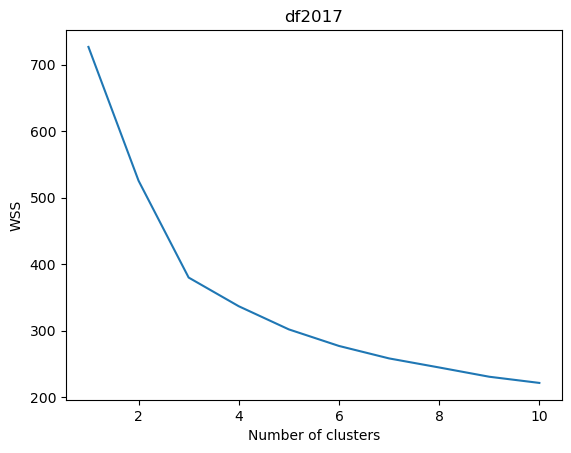

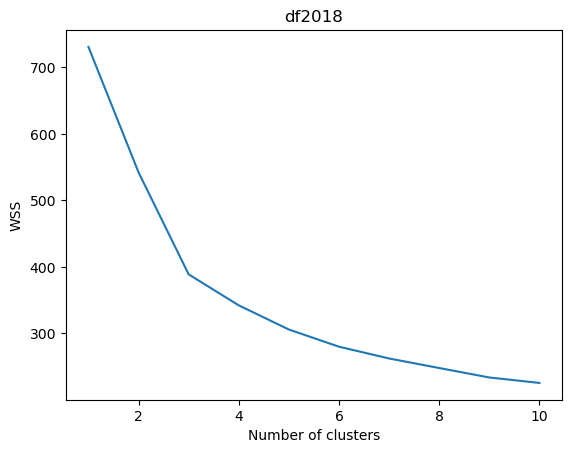

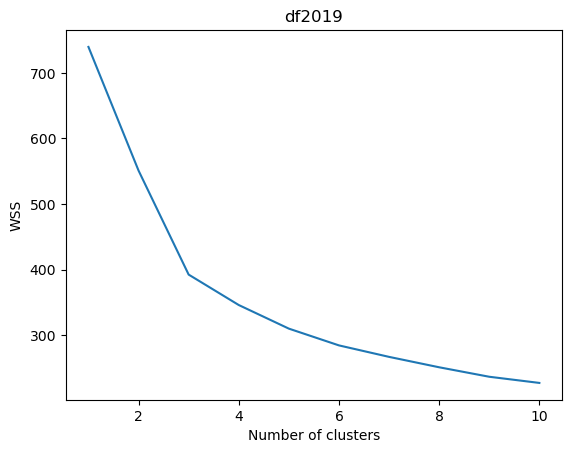

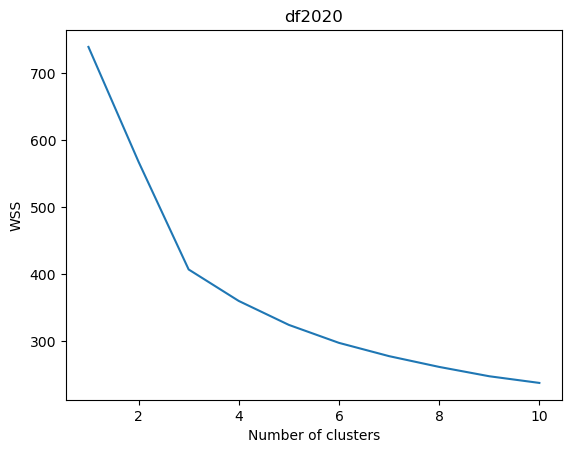

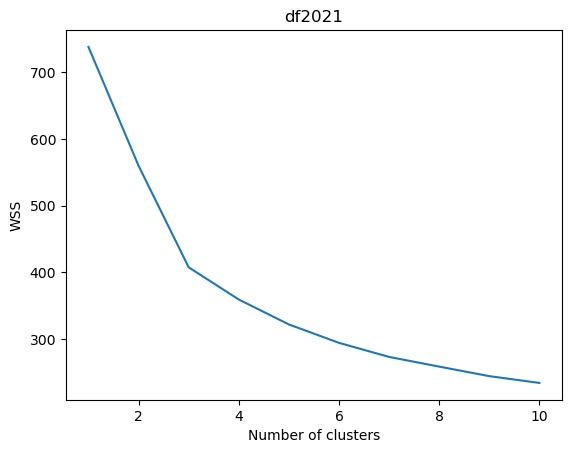

In [21]:
%%time
for key, df in dfs.items():
    print(f"Beginning df{year} clustering")
    wss_df = []
    scaler = MinMaxScaler()
    print(f"Scaling {key} columns")
    scaler.fit(df[['popDensity', 'incomePerCapita','housingMedianValue','housingMedianGrossRent']])
    df[['popDensity', 'incomePerCapita','housingMedianValue','housingMedianGrossRent']] = scaler.transform(df[['popDensity', 'incomePerCapita','housingMedianValue','housingMedianGrossRent']])
    print(f"KMeans clustering on {key}")
    for i in range(1,11):
        KM = KMeans(n_clusters=i)
        KM.fit(df)
        wss_df.append(KM.inertia_)
    plt.figure()
    plt.title(key)
    plt.xlabel("Number of clusters")
    plt.ylabel("WSS")
    plt.plot(range(1,11), wss_df)

### Silhouette score

In [22]:
%%time
for key, df in dfs.items():
    k_means = KMeans(n_clusters = 2)
    k_means.fit(df)
    labels = k_means.labels_
    df["Clus_kmeans"] = labels
    print(f"silhouette_score for {key}", round(silhouette_score(df,labels),3))

silhouette_score for df2017 0.667
silhouette_score for df2018 0.662
silhouette_score for df2019 0.658
silhouette_score for df2020 0.648
silhouette_score for df2021 0.586
CPU times: total: 16.7 s
Wall time: 5.54 s


### Mean values of the two clusters

In [23]:
%%time
for key, df in dfs.items():
    kmeans_data=df.groupby('Clus_kmeans').mean()
    kmeans_data['Freq']=df.Clus_kmeans.value_counts().sort_index()
    display(key, kmeans_data)

'df2017'

underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
Clus_kmeans                                                                     
0                     0.0                           0.099324         0.189962   
1                     1.0                           0.273372         0.094146   

             incomeGiniIndex  popDensity  whiteMajority  \
Clus_kmeans                                               
0                   0.416399    0.020795       0.886117   
1                   0.468907    0.092567       0.589829   

             eduHsOrLessProportion  eduHsProportion  \
Clus_kmeans                                           
0                         0.101001         0.625267   
1                         0.212302         0.626389   

             eduBachOrBetterProportion  eduEnrollmentProportion  ...  \
Clus_kmeans                                                      ...   
0                             0.273732                 0.223476  ...   
1                             0.161309                 0.274009  ...   

             employedPvtSecProportion  employedPubSecProportion  \
Clus_kmeans                                                       
0                            0.652812                  0.145611   
1                            0.687311                  0.126071   

             employedSelfEmpProportion  employedPvtNonProProportion  \
Clus_kmeans                                                           
0                             0.098252                     0.101214   
1                             0.071641                     0.112821   

             employedUnpaidFamProportion  insuredProportion  \
Clus_kmeans                                                   
0                               0.002111           0.931310   
1                               0.002155           0.883546   

             housingRentMoreThan30pcProportion  housingMedianValue  \
Clus_kmeans                                                          
0                                     0.402221            0.100260   
1                                     0.507903            0.072042   

             housingMedianGrossRent  Freq  
Clus_kmeans                                
0                          0.222421  2706  
1                          0.173797   181  

[2 rows x 22 columns]

'df2018'

underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
Clus_kmeans                                                                     
0                     1.0                           0.271247         0.103515   
1                     0.0                           0.098312         0.207157   

             incomeGiniIndex  popDensity  whiteMajority  \
Clus_kmeans                                               
0                   0.470212    0.082221       0.604366   
1                   0.417317    0.022629       0.882209   

             eduHsOrLessProportion  eduHsProportion  \
Clus_kmeans                                           
0                         0.207319         0.636368   
1                         0.098352         0.621789   

             eduBachOrBetterProportion  eduEnrollmentProportion  ...  \
Clus_kmeans                                                      ...   
0                             0.156313                 0.273524  ...   
1                             0.279859                 0.220938  ...   

             employedPvtSecProportion  employedPubSecProportion  \
Clus_kmeans                                                       
0                            0.693374                  0.118852   
1                            0.652662                  0.145072   

             employedSelfEmpProportion  employedPvtNonProProportion  \
Clus_kmeans                                                           
0                             0.073078                     0.113356   
1                             0.098483                     0.101507   

             employedUnpaidFamProportion  insuredProportion  \
Clus_kmeans                                                   
0                               0.001340            0.89715   
1                               0.002276            0.94049   

             housingRentMoreThan30pcProportion  housingMedianValue  \
Clus_kmeans                                                          
0                                     0.496339            0.064771   
1                                     0.398693            0.102034   

             housingMedianGrossRent  Freq  
Clus_kmeans                                
0                          0.165990   170  
1                          0.217785  2712  

[2 rows x 22 columns]

'df2019'

underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
Clus_kmeans                                                                     
0                     0.0                           0.095851         0.207369   
1                     1.0                           0.264409         0.101535   

             incomeGiniIndex  popDensity  whiteMajority  \
Clus_kmeans                                               
0                   0.417920    0.022992       0.880210   
1                   0.470584    0.085975       0.611257   

             eduHsOrLessProportion  eduHsProportion  \
Clus_kmeans                                           
0                         0.095682         0.618405   
1                         0.204993         0.635218   

             eduBachOrBetterProportion  eduEnrollmentProportion  ...  \
Clus_kmeans                                                      ...   
0                             0.285913                 0.218086  ...   
1                             0.159790                 0.277818  ...   

             employedPvtSecProportion  employedPubSecProportion  \
Clus_kmeans                                                       
0                            0.650772                  0.146314   
1                            0.690552                  0.122288   

             employedSelfEmpProportion  employedPvtNonProProportion  \
Clus_kmeans                                                           
0                             0.097535                     0.103086   
1                             0.074235                     0.111116   

             employedUnpaidFamProportion  insuredProportion  \
Clus_kmeans                                                   
0                               0.002292           0.945344   
1                               0.001810           0.907297   

             housingRentMoreThan30pcProportion  housingMedianValue  \
Clus_kmeans                                                          
0                                     0.393905            0.104994   
1                                     0.495828            0.071530   

             housingMedianGrossRent  Freq  
Clus_kmeans                                
0                          0.216776  2685  
1                          0.163586   171  

[2 rows x 22 columns]

'df2020'

underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
Clus_kmeans                                                                     
0                     1.0                           0.266582         0.087622   
1                     0.0                           0.093918         0.180780   

             incomeGiniIndex  popDensity  whiteMajority  \
Clus_kmeans                                               
0                   0.469317    0.082241       0.589462   
1                   0.417489    0.023284       0.866852   

             eduHsOrLessProportion  eduHsProportion  \
Clus_kmeans                                           
0                         0.196276         0.633366   
1                         0.092936         0.613133   

             eduBachOrBetterProportion  eduEnrollmentProportion  ...  \
Clus_kmeans                                                      ...   
0                             0.170358                 0.275514  ...   
1                             0.293932                 0.215336  ...   

             employedPvtSecProportion  employedPubSecProportion  \
Clus_kmeans                                                       
0                            0.669233                  0.132546   
1                            0.644383                  0.149133   

             employedSelfEmpProportion  employedPvtNonProProportion  \
Clus_kmeans                                                           
0                             0.074650                     0.120093   
1                             0.098268                     0.105942   

             employedUnpaidFamProportion  insuredProportion  \
Clus_kmeans                                                   
0                               0.003478           0.911378   
1                               0.002274           0.945876   

             housingRentMoreThan30pcProportion  housingMedianValue  \
Clus_kmeans                                                          
0                                     0.474961            0.080058   
1                                     0.385806            0.117230   

             housingMedianGrossRent  Freq  
Clus_kmeans                                
0                          0.188215   155  
1                          0.246764  2656  

[2 rows x 22 columns]

'df2021'

underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
Clus_kmeans                                                                     
0                0.097622                           0.105409         0.262380   
1                0.032603                           0.101306         0.155963   

             incomeGiniIndex  popDensity  whiteMajority  \
Clus_kmeans                                               
0                   0.457887    0.086587       0.647982   
1                   0.407242    0.003707       0.921016   

             eduHsOrLessProportion  eduHsProportion  \
Clus_kmeans                                           
0                         0.093968         0.442211   
1                         0.097208         0.679195   

             eduBachOrBetterProportion  eduEnrollmentProportion  ...  \
Clus_kmeans                                                      ...   
0                             0.463821                 0.251248  ...   
1                             0.223597                 0.205740  ...   

             employedPvtSecProportion  employedPubSecProportion  \
Clus_kmeans                                                       
0                            0.627183                  0.146992   
1                            0.649671                  0.150106   

             employedSelfEmpProportion  employedPvtNonProProportion  \
Clus_kmeans                                                           
0                             0.103915                     0.120309   
1                             0.093597                     0.104054   

             employedUnpaidFamProportion  insuredProportion  \
Clus_kmeans                                                   
0                               0.001601           0.953794   
1                               0.002572           0.940124   

             housingRentMoreThan30pcProportion  housingMedianValue  \
Clus_kmeans                                                          
0                                     0.474563            0.233601   
1                                     0.357962            0.073354   

             housingMedianGrossRent  Freq  
Clus_kmeans                                
0                          0.390381   799  
1                          0.153931  1963  

[2 rows x 22 columns]

CPU times: total: 62.5 ms
Wall time: 226 ms


In [24]:
dfs['df2021']

underPoverty  incomeBelowPovertyLevelProportion  incomePerCapita  \
zip_code                                                                     
10001                0                           0.122854         0.508061   
10002                0                           0.247883         0.185064   
10003                0                           0.113830         0.578844   
10004                0                           0.029659         0.814405   
10005                0                           0.039515         0.706542   
...                ...                                ...              ...   
19971                0                           0.076859         0.380454   
19973                0                           0.148420         0.143945   
19975                0                           0.068004         0.238288   
19977                0                           0.096219         0.151156   
19979                0                           0.082090         0.176028   

          incomeGiniIndex  popDensity  whiteMajority  eduHsOrLessProportion  \
zip_code                                                                      
10001              0.5524    0.285369       0.629051               0.072220   
10002              0.5922    0.616638       0.321416               0.322255   
10003              0.5532    0.628712       0.706761               0.036181   
10004              0.4566    0.069479       0.575182               0.003587   
10005              0.3579    0.782497       0.752113               0.000879   
...                   ...         ...            ...                    ...   
19971              0.5314    0.005189       0.873479               0.037551   
19973              0.4386    0.002008       0.655685               0.138117   
19975              0.4447    0.002479       0.912903               0.088996   
19977              0.4006    0.002052       0.583626               0.088187   
19979              0.2933    0.001283       0.973479               0.074510   

          eduHsProportion  eduBachOrBetterProportion  eduEnrollmentProportion  \
zip_code                                                                        
10001            0.196375                   0.731405                 0.166287   
10002            0.313974                   0.363771                 0.172863   
10003            0.140121                   0.823698                 0.283022   
10004            0.030905                   0.965508                 0.131993   
10005            0.072339                   0.926783                 0.101182   
...                   ...                        ...                      ...   
19971            0.444506                   0.517943                 0.084714   
19973            0.683015                   0.178868                 0.215841   
19975            0.535339                   0.375665                 0.128656   
19977            0.686645                   0.225168                 0.225877   
19979            0.762745                   0.162745                 0.256735   

          ...  employedPvtSecProportion  employedPubSecProportion  \
zip_code  ...                                                       
10001     ...                  0.726459                  0.060124   
10002     ...                  0.699130                  0.102674   
10003     ...                  0.684703                  0.054752   
10004     ...                  0.658673                  0.079415   
10005     ...                  0.815560                  0.068808   
...       ...                       ...                       ...   
19971     ...                  0.555074                  0.131681   
19973     ...                  0.658000                  0.129845   
19975     ...                  0.647491                  0.169400   
19977     ...                  0.624378                  0.240974   
19979     ...                  0.556675                  0.335013   

          emplo